# Above Threshold Building Energy Usage Classification

### Import Data and Libraries

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import pickle
import scipy as sc

# Importing the dataset

df1 = pd.read_csv('../data/year_data/2018-04-01_2018-04-29.csv')
df2 = pd.read_csv('../data/year_data/2018-05-01_2018-05-30.csv')
df3 = pd.read_csv('../data/year_data/2018-06-01_2018-08-30.csv')
df =  pd.concat([df1, df2, df3], ignore_index=True)
#df.isna().sum().sum()

## Functions

#### Dataframe Manipulation

In [2]:
# Slices the Dataframe by both Date and Buildings
def slice_df(start_date, num_days=7, num_min=0, bldgs=None, df=df):
    start, end = slice_df_by_date(start_date, num_days, num_min, df)
    return slice_df_by_bldg(bldgs, df.iloc[start:end,:])

# Returns starting and ending indexes of data splice
def slice_df_by_date(start_date, num_days=7, num_min=0, df=df):
    start = df.index[df['time'] == start_date + ' 00:00'].tolist()[0]
    end = start + num_days * 96 + num_min % 15
    return start, end

# Returns df of Selected Columns (None == All)
def slice_df_by_bldg(bldgs=None, df=df):
    if bldgs == None: return df.iloc[:, 1:]
    else: return df[bldgs]

# Split Time Stamp Column to Two Columns; Date and Time
def split_date_time(df=df):
    df['date'] = df['time'].apply(lambda x: x.split(x)[0])
    df['time'] = df['time'].apply(lambda x: x.split(x)[1])
    return df


# Group By Interval with some Method
# Methods: Sum, Mean, Min, or Max
# Returns a df of grouped data
def group_df(method="mean", interval='day', has_time_col=True, df=df):
    interval = time_to_row(interval)
    grouped_df = pd.DataFrame()   
    for i in range(0,len(df)//interval):
        if has_time_col: start_date = df['time'][i*interval]
        block = df.iloc[ i*interval:(i+1)*interval, : ]
        # Perform Computation on Row
        if method == "sum": block = block.sum(axis=0)
        elif method == "mean": block = block.mean(axis=0)
        elif method == "min": block = block.min(axis=0)
        elif method == "max": block = block.max(axis=0)
        else:
            print("Invalid Method Entry")
            return
        # Add the Start Date Label
        if has_time_col:
            if method == "mean": block = pd.Series([start_date]).append(block)  
            else: block[0] = start_date
        block = block.to_frame().transpose()
        grouped_df = grouped_df.append(block)
    if method == "mean" and has_time_col: grouped_df = grouped_df.rename(columns={ grouped_df.columns[0]: "time" })
    return grouped_df

# Create Training Data
def training_data(start_date, y=None, num_days=7, num_min=0, bldgs=None, method="mean", agg_interval='hour',
                  time_interval="day", has_time_col=True, df=df):
    # Slice Data by Time and Buildings
    X = slice_df(start_date, num_days, num_min, bldgs, df)
    X = X.rename(columns={ X.columns[0]: "time" })
    # Aggregate Data on Interval
    X = group_df(method=method, interval=agg_interval, has_time_col=False, df=X)
    if has_time_col: X = X.drop(columns=['time'])
    # Determine Shape of New Dataframe and Reshape
    new_col_ct = int(time_to_row(time_interval)/time_to_row(agg_interval))
    rows_per_instance = int(X.shape[0]/new_col_ct)
    X = X.T.values.reshape(X.shape[1] * rows_per_instance, new_col_ct)
    # Return X or both X and updated y if y is given
    if y == None: return pd.DataFrame(X)
    updated_y = []
    for i in y:
        for j in range(0, rows_per_instance): updated_y.append(i)
    return pd.DataFrame(X), updated_y

# Reshape Training Data
def reshape_data(df, has_time_col=True, agg_interval="0:15", time_interval="day"):
    X = df
    if has_time_col: X = X.drop(columns=['time'])
    # Determine Shape of New Dataframe and Reshape
    new_col_ct = int(time_to_row(time_interval)/time_to_row(agg_interval))
    rows_per_instance = int(X.shape[0]/new_col_ct)
    X = X.T.values.reshape(X.shape[1] * rows_per_instance, new_col_ct)
    return X

#### Conversion

In [3]:
# Convert a time interval into the correct number of rows
# Interval: "3:15", "hour", day", "week", "month", "year" 
def time_to_row(interval):
    time_conv =	{ "year": 35040, "month": 2880, "week": 672, "day": 96, "hour": 4}
    if interval in time_conv: return time_conv[interval]
    elif ":" in interval: return int(interval.split(':')[0])*4 + int(interval.split(':')[1])//15
    else: return

# Converts the Date into a Number
def date_to_num(date):
    d,t = date.split()
    y,m,day = d.split('-')
    hr, minute = t.split(':')
    return int(y + m + day + hr + minute)

# Converts Traditional Date Format '4/4/2018' to ISO '2018-04-01'
def date_to_iso(date):
    month, day, year = date.split('/')
    if (int(month) < 10): month = '0' + str(int(month))
    if (int(day) < 10): day = '0' + str(int(day))
    return year + '-' + month + '-' + day

# Converts a Date Number to Proper Date Format
def num_to_date(date):
    date = str(date)
    return date[0:4] + '-' + date[4:6] + '-' + date[6:8] + ' ' + date[8:10] + ':' + date[10:12]

# Convert Number to Building Type Classification
def num_to_label(num):
    conv = {0: 'Cocentric', 1: 'People', 2: 'Schedule', 3: 'Reverse', 4: 'Random'}
    if num in conv: return conv[num]
    return "Invalid Entry"

# Returns rotates array n times, clockwise by default
def rotate_list(arr, n):
    arr = list(arr)
    if n >= 0: return arr[-n:] + arr[:-n]
    return arr[abs(n):] + arr[:abs(n)]

# Convert From LabelEncoded to OneHotEncoded
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
def label_to_one_hot(y):
    one_hot_encoder = OneHotEncoder()
    return one_hot_encoder.fit_transform(y).toarray()

# Convert From OneHotEncoded to LabelEncoded
def one_hot_to_label(y):
    return [ np.argmax(i) for i in y ]

C:\Users\15103\Anaconda3\envs\build\lib\site-packages\sklearn\utils\__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


#### Fingerprint Generation

In [4]:
def fingerprint_draw(bldg, save=False, show=False, df=df):
    r = df[bldg]
    theta = []
    for i in range(0, len(r)):
        theta.append((i%96)/96 * 2 * np.pi)
    r = r.append(pd.Series(r.values[0]))
    theta.append(0)
    fig = plt.figure()
    ax = plt.subplot(111, projection='polar', facecolor='white')
    ax.plot(theta, r, c='y')
    ax.set_xticklabels(['12am', '3am', '6am', '9am', '12pm', '3pm', '6pm', '9pm'])
    plt.figure(figsize=(4,4))
    ax.set_rlabel_position(90)
    ax.grid(True)
    ax.grid(linewidth=.3)
    ax.set_title("Energy Usage of Building " + bldg + " (kWh)", va='bottom')
    ax.title.set_position([.5, 1.15])
    if save: fig.savefig('fingerprints/' + bldg + '.png', bbox_inches='tight')
    if show: plt.show()

#fingerprint('2018-02-08', 1, bldgs=['B104'], save=False)
#fingerprint('2018-01-01', 1)
#fingerprint('2018-01-01', num_days=5, save=True)
def fingerprint(start_date, num_days=7, num_min=0, bldgs=None, save=True, df=df):
    df = slice_df(start_date, num_days, num_min, bldgs, df)    
    for bldg in df.columns: fingerprint_draw(bldg, save, df=df)

### Data Manipulation

In [5]:
# Returns a Stacked dataframe with each rotation of each row
def rotate_data(X, y, iterations = 1, ret_orig = True):
    final_X, final_y = pd.DataFrame(), pd.DataFrame()
    for itr in range(0, iterations):
        new_df = []
        for i in range(0, X.shape[0]):
            new_df.append(rotate_list( X.iloc[i, :].values, itr - (iterations // 2) ))
        final_X = pd.concat([final_X, pd.DataFrame(new_df)])
        final_y = pd.concat([final_y, pd.DataFrame(y)])
    if ret_orig: return pd.concat([X, final_X]), pd.concat([y, final_y])
    return final_X, final_y

# Remove Buildings With Energy Usage Below 60 kwH
def remove_small(X, y, thresh=75):
    final_X, final_y = pd.DataFrame(), pd.DataFrame()
    y_list = list(y.iloc[:, 0])
    new_df = []
    new_y = []
    for i in range(0, X.shape[0]):
        if X.iloc[i, :].mean() > thresh:
            new_df.append(X.iloc[i, :].values)
            new_y.append(y_list[i])
    final_X = pd.concat([final_X, pd.DataFrame(new_df)])
    final_y = pd.concat([final_y, pd.DataFrame(new_y)])
    return final_X, final_y


# Subtract Row Elements by Min Value in Row
def minus_min(X):
    new_X = []
    for i in range(0, X.shape[0]): new_X.append(X.iloc[i, :] - min(X.iloc[i, :]))
    return pd.DataFrame(new_X)

# Normalize Each Row Independently
from sklearn.preprocessing import normalize
def norm_rows(X):
    new_X = []
    for i in range(0, X.shape[0]):
        new_row = [list(X.iloc[i, :])]
        new_row = normalize(new_row)
        new_X.append(new_row)
    return pd.DataFrame(new_X)

# Square Each Row Independently
def square_rows(X):
    new_X = []
    for i in range(0, X.shape[0]):
        new_row = X.iloc[i, :]
        for i,v in enumerate(new_row):
            new_row[i] = v*v
        new_X.append(new_row)
    return pd.DataFrame(new_X)

#### Accuracy Reporting

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Use this function for non-binary classification
def confusion_matrix_multi(y_test, y_pred):
    if pd.DataFrame(y_pred).shape[1] == 1:
        y_pred = label_to_one_hot(pd.DataFrame(y_pred))
    conf_mat = confusion_matrix(one_hot_to_label(y_test), one_hot_to_label(y_pred))
    fig, ax = plt.subplots(figsize=(10,10))
    classes = ['Cocentric', 'People', 'Schedule', 'Reverse', 'Random']
    sns.heatmap(conf_mat, annot=True, fmt='d',
                    xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    accuracy = conf_mat_acc(conf_mat)
    plt.title('Accuracy: ' + str(accuracy) + '%', fontsize=20)
    plt.show()
    return accuracy

# Calculates the Accuracy for any n by n conf matrix
def conf_mat_acc(conf_mat):
    acc = 0
    for i in range(0, len(conf_mat)):
        for j in range(0, len(conf_mat)):
            if i == j: acc += conf_mat[i][j]
    acc = acc/sum(sum(conf_mat))
    acc = round(acc * 100, 2)
    return acc

# Print All Misclassified Instances
def print_misclassified(predicted, actual, X_test, y_test, y_pred, sc, relabel=False):
    y_test = one_hot_to_label(y_test)
    y_pred = one_hot_to_label(y_pred)
    X_test = pd.DataFrame(sc.inverse_transform(X_test))
    for i in range(0, X_test.shape[0]):
        if(y_pred[i] == predicted and y_test[i] == actual):
            title = "Predicted: " + num_to_label(predicted) + ". Actual: " + num_to_label(actual)
            fingerprint_draw_r( title, X_test.iloc[i, :], save=False, show=True, df=df)
            if relabel: search_fingerprint(X_test.iloc[i, :])
                
# Search Data For Fingerprint Match to Relabel the Classification
def search_fingerprint(data, csv='labeled_data.csv'):
    labeled_df = pd.read_csv(csv)
    labeled_dates = labeled_df[labeled_df.columns[0]]
    relabel_val = input("Enter Relabel Value (Enter 'n' to skip): ")
    no_match = True
    if relabel_val in ['0', '1', '2', '3', '4']:
        for date in labeled_dates:
            sliced_df = slice_df(date_to_iso(date), num_days=1, df=df)
            sliced_df = sliced_df.reset_index(drop=True)
            for col in sliced_df:
                if round(data[0], 2) == sliced_df.at[0, col]:
                    for i in range(0,96):
                        if( round(data[i], 2) != sliced_df.at[i, col]): break
                        if(i == 95): 
                            no_match = False
                            print("Building: " + col + ' on ' + date + ' updated to ' + str(relabel_val))
                            update_label(col, date, int(relabel_val))
    if no_match: print('No Matches')

# Print all Misclassified Instances
def print_all_misclassified(X_test, y_test, y_pred, sc):
    for i in range(0, 5):
        for j in range(0, 4):
            if i != j: print_misclassified(i, j, X_test, y_test, y_pred, sc, relabel=True)

#### Data Update

In [7]:
# bldg - str, date (mm/dd/yy) - str, update_val (label 0-4) - str, csv (file to update) - string
def update_label(bldg, date, update_val, csv='labeled_data.csv'):
    df = pd.read_csv(csv)
    index = df.index[df[df.columns[0]] == date].tolist()[0]
    df.at[index, bldg] = update_val
    df.to_csv(csv, index=False)

#### Classification Tools

In [8]:
# Plot the Feature Importances After Creating a Decision Tree Classifying Object
def plot_feature_importances(model, n_features):
    plt.figure(figsize=(8,6))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), df.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.title("Decision Tree Feature Importance")
    plt.show()
    
from sklearn.neighbors import KNeighborsClassifier
# Test Different Values of k for K-NN Classification
def knn_test_k(start=1, end=10):
    training_accuracy = []
    test_accuracy = []
    neighbors_settings = range(start, end)
    for n_neighbors in neighbors_settings:
        knn = KNeighborsClassifier(p=2, n_neighbors=n_neighbors)
        knn.fit(X_train, y_train)
        training_accuracy.append(knn.score(X_train, y_train))
        test_accuracy.append(knn.score(X_test, y_test))
    plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
    plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("n_neighbors")
    plt.legend()
    plt.show()
    return test_accuracy.index(max(test_accuracy)) + 1
    #plt.savefig('knn_compare_model')

## Data Preprocessing

#### Format Labeled Data

In [9]:
#update_label('B110', '4/6/2018', 0)
y_labels = pd.read_csv('../data/labeled_data.csv')
#y_labels

In [10]:
y1 = y_labels.iloc[:3, :]
y1 = y1.melt()
y1 = pd.DataFrame(y1.iloc[3:len(y1)-3,1])

# Get Original Data
X1 = training_data(start_date='2018-04-04', y=None, num_days=3, num_min=0, method="mean", agg_interval='0:15',
                  time_interval="day", has_time_col=False, df=df)

y1.shape[0] == X1.shape[0]

True

In [11]:
y2 = y_labels.iloc[3:8, :]
y2 = y2.melt()
y2 = pd.DataFrame(y2.iloc[5:len(y2)-5,1])

X2 = training_data(start_date='2018-04-09', y=None, num_days=5, num_min=0, method="mean", agg_interval='0:15',
                  time_interval="day", has_time_col=False, df=df)

y2.shape[0] == X2.shape[0]

True

In [12]:
y3 = y_labels.iloc[8:10, :]
y3 = y3.melt()
y3 = pd.DataFrame(y3.iloc[2:len(y3)-2, 1])

X3 = training_data(start_date='2018-06-21', y=None, num_days=2, num_min=0, method="mean", agg_interval='0:15',
                  time_interval="day", has_time_col=False, df=df)

y3.shape[0] == X3.shape[0]

True

In [13]:
y4 = y_labels.iloc[10:15, :]
y4 = y4.melt()
y4 = pd.DataFrame(y4.iloc[5:len(y4)-5, 1])

X4 = training_data(start_date='2018-06-25', y=None, num_days=5, num_min=0, method="mean", agg_interval='0:15',
        time_interval="day", has_time_col=False, df=df)

y4.shape[0] == X4.shape[0]

True

In [14]:
y5 = y_labels.iloc[15:17, :]
y5 = pd.DataFrame(y5).melt()
y5 = pd.DataFrame(y5.iloc[2:len(y5)-2, 1])

X5 = training_data(start_date='2018-07-02', y=None, num_days=2, num_min=0, method="mean", agg_interval='0:15',
                  time_interval="day", has_time_col=False, df=df)

y5.shape[0] == X5.shape[0]

True

In [15]:
y6 = y_labels.iloc[17:19, :]
y6 = pd.DataFrame(y6).melt()
y6 = pd.DataFrame(y6.iloc[2:len(y6)-2, 1])

X6 = training_data(start_date='2018-07-05', y=None, num_days=2, num_min=0, method="mean", agg_interval='0:15',
                  time_interval="day", has_time_col=False, df=df)

y6.shape[0] == X6.shape[0]

True

In [16]:
y7 = y_labels.iloc[19:22, :]
y7 = pd.DataFrame(y7).melt()
y7 = pd.DataFrame(y7.iloc[3:len(y7)-3, 1])

X7 = training_data(start_date='2018-07-09', y=None, num_days=3, num_min=0, method="mean", agg_interval='0:15',
                  time_interval="day", has_time_col=False, df=df)

y7.shape[0] == X7.shape[0]

True

#### Concat

In [17]:
y = pd.concat([y1, y2, y3, y4, y5, y6, y7], axis=0)
y.shape

(2926, 1)

In [18]:
X = pd.concat([X1, X2, X3, X4, X5, X6, X7], axis=0)
X.shape

(2926, 96)

In [19]:
# Remove Buildings With Energy Usage Below Threshold
X, y = remove_small(X, y, 125)

In [20]:
X.shape

(1076, 96)

#### One Hot Encode Y Values

In [21]:
y = label_to_one_hot(y)

#### Splitting the dataset into the Training set and Test set

In [22]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0) # Original 0.20

C:\Users\15103\Anaconda3\envs\build\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Feature Scaling

In [23]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [24]:
# Multiply Datasize
X_train_n, y_train_n = rotate_data(pd.DataFrame(X_train), pd.DataFrame(y_train), 10, ret_orig=False)
X_train = pd.concat([pd.DataFrame(X_train), X_train_n])
y_train = pd.concat([pd.DataFrame(y_train), y_train_n])
X_train = X_train.values
y_train = y_train.values
print('Final Shapes:')
print(X_train.shape)
print(y_train.shape)

Final Shapes:
(11836, 96)
(11836, 5)


## Model Training

### Decision Tree Classification

In [25]:
'''
# Fitting Decision Tree Classification to the Training set
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', min_impurity_split=0.27)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
confusion_matrix_multi(y_test, y_pred)
'''

"\n# Fitting Decision Tree Classification to the Training set\nfrom sklearn.tree import DecisionTreeClassifier\nclassifier = DecisionTreeClassifier(criterion = 'entropy', min_impurity_split=0.27)\nclassifier.fit(X_train, y_train)\ny_pred = classifier.predict(X_test)\nconfusion_matrix_multi(y_test, y_pred)\n"

In [26]:
#print_all_misclassified(X_test, y_test, y_pred, sc)

In [27]:
#plot_feature_importances(classifier,96)

In [28]:
# Visualize Decision Tree
'''
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
'''

'\nfrom sklearn.externals.six import StringIO  \nfrom IPython.display import Image  \nfrom sklearn.tree import export_graphviz\nimport pydotplus\ndot_data = StringIO()\nexport_graphviz(classifier, out_file=dot_data,  \n                filled=True, rounded=True,\n                special_characters=True)\ngraph = pydotplus.graph_from_dot_data(dot_data.getvalue())  \nImage(graph.create_png())\n'

### Random Forest Classification

In [29]:
'''
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators = 200, criterion = 'entropy') 
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
confusion_matrix_multi(y_test, y_pred)
'''

"\nfrom sklearn.ensemble import RandomForestClassifier\nrf_classifier = RandomForestClassifier(n_estimators = 200, criterion = 'entropy') \nrf_classifier.fit(X_train, y_train)\ny_pred = rf_classifier.predict(X_test)\nconfusion_matrix_multi(y_test, y_pred)\n"

In [30]:
#print_all_misclassified(X_test, y_test, y_pred, sc)

### K-NN Classification

In [31]:
'''best_k = knn_test_k()'''

'best_k = knn_test_k()'

In [32]:
'''
# Fitting K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors = best_k, metric = 'minkowski', p = 2)
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)
print('Optimal k Value: ' + str(best_k))
confusion_matrix_multi(y_test, y_pred)
'''

"\n# Fitting K-NN to the Training set\nfrom sklearn.neighbors import KNeighborsClassifier\nknn_classifier = KNeighborsClassifier(n_neighbors = best_k, metric = 'minkowski', p = 2)\nknn_classifier.fit(X_train, y_train)\ny_pred = knn_classifier.predict(X_test)\nprint('Optimal k Value: ' + str(best_k))\nconfusion_matrix_multi(y_test, y_pred)\n"

In [33]:
#print_all_misclassified(X_test, y_test, y_pred, sc)

### Artificial Neural Network Classification

In [34]:
'''
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(30, 20, 10, 8), max_iter=300)
mlp.fit(X_train,y_train)
y_pred = mlp.predict(X_test)
confusion_matrix_multi(y_test, y_pred)
'''

'\nfrom sklearn.neural_network import MLPClassifier\nmlp = MLPClassifier(hidden_layer_sizes=(30, 20, 10, 8), max_iter=300)\nmlp.fit(X_train,y_train)\ny_pred = mlp.predict(X_test)\nconfusion_matrix_multi(y_test, y_pred)\n'

### Ensemble Classification

In [35]:
'''
# Voting Ensemble for Classification
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
# create the sub models
estimators = []
estimators.append(('Random Forest', rf_classifier))
estimators.append(('KNN', knn_classifier))
estimators.append(('ANN', mlp))
# create the ensemble model
ensemble = VotingClassifier(estimators)
#results = model_selection.cross_val_score(ensemble, X_train, one_hot_to_label(y_train), cv=kfold)
'''

"\n# Voting Ensemble for Classification\nfrom sklearn import model_selection\nfrom sklearn.ensemble import VotingClassifier\nseed = 7\nkfold = model_selection.KFold(n_splits=10, random_state=seed)\n# create the sub models\nestimators = []\nestimators.append(('Random Forest', rf_classifier))\nestimators.append(('KNN', knn_classifier))\nestimators.append(('ANN', mlp))\n# create the ensemble model\nensemble = VotingClassifier(estimators)\n#results = model_selection.cross_val_score(ensemble, X_train, one_hot_to_label(y_train), cv=kfold)\n"

In [36]:
'''
ensemble = ensemble.fit(X_train, one_hot_to_label(y_train))
y_pred_ensemble = ensemble.predict(X_test)
confusion_matrix_multi(y_test, y_pred_ensemble)
'''

'\nensemble = ensemble.fit(X_train, one_hot_to_label(y_train))\ny_pred_ensemble = ensemble.predict(X_test)\nconfusion_matrix_multi(y_test, y_pred_ensemble)\n'

#### Save Model

In [37]:
'''
# Save Results
import pickle
# save the model to disk
filename = 'building_classification_model.p'
pickle.dump(ensemble, open(filename, 'wb'))
'''

"\n# Save Results\nimport pickle\n# save the model to disk\nfilename = 'building_classification_model.p'\npickle.dump(ensemble, open(filename, 'wb'))\n"

## Classification

#### Import Dataset and Preprocess

In [38]:
# Importing the Dataset
df_8mo = pd.read_csv('../data/year_data/2018-01-01_2018-08-30.csv')

In [39]:
# Replace Nan's with 0
for i in range(1, df_8mo.shape[1]): df_8mo.iloc[1:, i] = df_8mo.iloc[1:, i].fillna(0)

In [40]:
df_8mo

,time,B101,B103,B104,B107,B108,B109,B110,B111,B114,...,B051D,B051F,B051F_C1,B051F_C2,B051F_C3,B060A,B061A,B080A,B172W,B195W
0,1/1/2018 0:00,51.77,331.61,132.74,18.07,34.56,30.15,27.02,112.87,64.97,...,263.88,839.11,0.0,0.0,109.0,42.53,98.11,7.0,765.24,603.74
1,1/1/2018 0:15,51.94,328.49,135.46,18.01,34.20,30.79,27.18,111.47,64.12,...,265.17,842.14,0.0,0.0,109.0,20.70,98.05,7.0,764.57,596.06
2,1/1/2018 0:30,50.25,329.25,136.93,18.48,34.73,30.88,27.45,112.41,61.85,...,264.35,841.76,0.0,0.0,102.0,18.34,97.36,9.0,739.16,616.51
3,1/1/2018 0:45,49.47,324.16,135.75,18.85,34.24,31.66,27.35,111.43,65.34,...,264.52,846.41,0.0,0.0,106.0,18.21,97.00,7.0,773.27,596.79
4,1/1/2018 1:00,53.68,326.08,132.03,19.15,34.58,31.19,27.12,111.77,61.93,...,265.36,835.65,0.0,0.0,106.0,19.71,102.23,7.0,751.77,607.46
5,1/1/2018 1:15,48.76,322.45,134.81,18.75,34.63,30.40,26.47,112.20,62.61,...,267.39,841.60,0.0,0.0,101.0,18.71,98.37,7.0,766.64,602.56
6,1/1/2018 1:30,49.24,325.78,132.46,17.98,34.69,30.25,26.52,111.20,61.74,...,265.60,841.37,0.0,0.0,102.0,18.83,99.18,7.0,695.59,529.78
7,1/1/2018 1:45,47.94,322.79,132.03,18.63,34.57,30.53,27.69,116.38,61.25,...,264.38,842.76,0.0,0.0,102.0,19.97,98.78,7.0,727.60,520.24
8,1/1/2018 2:00,48.82,330.68,132.89,18.37,34.54,30.23,27.09,112.53,62.79,...,265.67,841.05,0.0,0.0,119.0,19.24,98.53,7.0,749.62,513.02
9,1/1/2018 2:15,52.11,327.74,130.05,18.14,34.67,30.60,26.65,111.85,60.53,...,265.82,839.68,0.0,0.0,107.0,20.27,98.19,9.0,767.58,516.68


#### Format Data for Model Prediction

In [41]:
from sklearn.preprocessing import StandardScaler

# Format Energy Consumption Data
energy_data = reshape_data(df_8mo)
original_len = len(energy_data)

In [42]:
energy_data

array([[ 51.77,  51.94,  50.25, ...,  49.98,  51.12,  52.06],
       [ 51.91,  48.96,  50.73, ...,  55.42,  56.92,  56.48],
       [ 55.87,  54.85,  59.53, ...,  55.54,  52.31,  54.  ],
       ...,
       [631.97, 630.36, 633.73, ..., 638.98, 630.51, 631.29],
       [627.12, 642.  , 639.94, ..., 642.84, 638.64, 648.9 ],
       [639.05, 644.69, 624.87, ..., 643.8 , 645.79, 641.64]])

In [43]:
original_len

31758

In [44]:
energy_y = []
for i in range(len(energy_data)): energy_y.append(i)
energy_y = pd.DataFrame(energy_y)

energy_data, energy_y = remove_small(pd.DataFrame(energy_data), energy_y, thresh=125)
energy_y = energy_y.iloc[:, 0]

sc = StandardScaler()
energy_data = sc.fit_transform(energy_data)

# Get List of Buildings
buildings = list(df_8mo)[1:]

# Get List of dates
dates = pd.DataFrame(df_8mo.iloc[:,0])
dates = group_df(method="mean", interval='day', has_time_col=True, df=dates)
for i in range(dates.shape[0]): dates.iloc[i, 0] = dates.iloc[i, 0].split()[0]
dates = list(dates.iloc[:, 0])

In [45]:
reshape_data(df_8mo)

array([[ 51.77,  51.94,  50.25, ...,  49.98,  51.12,  52.06],
       [ 51.91,  48.96,  50.73, ...,  55.42,  56.92,  56.48],
       [ 55.87,  54.85,  59.53, ...,  55.54,  52.31,  54.  ],
       ...,
       [631.97, 630.36, 633.73, ..., 638.98, 630.51, 631.29],
       [627.12, 642.  , 639.94, ..., 642.84, 638.64, 648.9 ],
       [639.05, 644.69, 624.87, ..., 643.8 , 645.79, 641.64]])

#### Load Classification Model

In [46]:
filename = 'building_classification_model.p'
loaded_model = pickle.load(open(filename, 'rb'))
classifications = loaded_model.predict(energy_data)

C:\Users\15103\Anaconda3\envs\build\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\15103\Anaconda3\envs\build\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [47]:
#classifications

In [48]:
holidays = ['1/1/2016', '1/2/2016', '1/18/2016', '3/21/2016', '3/22/2016', '3/23/2016',
            '3/24/2016', '3/25/2016','9/5/2016', '10/10/2016', '10/11/2016', '11/23/2016',
            '11/24/2016', '11/25/2016','12/25/2016', '12/26/2016', '12/27/2016',
            '12/28/2016', '12/29/2016', '12/30/2016','12/31/2016', '1/1/2017', '1/2/2017',
            '1/16/2017', '3/19/2017', '3/20/2017','3/21/2017', '3/22/2017', '3/23/2017',
            '3/24/2017', '5/28/2017', '7/3/2017', '7/4/2017', '9/4/2017', '10/9/2017',
            '10/10/2017', '11/22/2017', '11/23/2017', '11/24/2017', '12/25/2017', '12/27/2017',
            '12/28/2017', '12/29/2017', '12/30/2017','12/31/2017', '1/1/2018', '1/2/2018',
           '1/15/2018', '3/19/2018', '3/20/2018', '3/21/2018', '3/22/2018', '3/23/2018',
           '5/28/2018', '7/3/2018', '7/4/2018', '9/3/2018', '10/8/2018', '10/9/2018',
           '11/21/2018', '11/22/2018', '11/23/2018', '12/24/2018', '12/25/2018',
            '12/26/2018', '12/27/2018', '12/28/2018']

In [49]:
# Get List of Day Types. 1-5: M-F, -1: Weekend, -2: Holiday
# Param dates: List of Dates in 'MM/DD/YYYY' Format
# Param holidays: List of Holidays in 'MM/DD/YY' Format
from datetime import date
def classify_day_type(dates, holidays):
    day_type = []
    for i in dates:
        date_elem = i.split('/')
        day_of_week = date(int(date_elem[2]), int(date_elem[0]), int(date_elem[1])).isoweekday()
        if day_of_week > 5: day_type.append(-1)
        elif i in holidays: day_type.append(-2)
        else: day_type.append(day_of_week)
    return day_type

In [50]:
# Create building_type Array
building_type = []
for i in range(original_len): building_type.append(-1)
for i in range(len(energy_y)): building_type[energy_y[i]] = classifications[i]
    
# Create Classification df Date, Building Type
dates = dates * 134
updated_bldg = [] 
for i in buildings: updated_bldg += [i] * 237
    
# Create List of Day Types
day_type = classify_day_type(dates, holidays)

In [51]:
# param arrays (arr) An array of arrays (data for each column)
# param labels (arr) An array of associated labels (str)
# return df final dataframe
def arrays_to_df(arrays, labels):
    if len(arrays) <= 1:
        print("Array must contain more than one array.")
        return
    # Start with First Column
    final_df = pd.DataFrame()
    # Add Remaining Arrays
    for i in range(0, len(arrays)):
        print(i)
        new_col = pd.DataFrame(arrays[i], columns=[labels[i]])
        final_df = pd.concat([final_df, new_col], axis=1)
    return final_df

In [52]:
# Create Building Classification Dataframe
#arrays = [day_type_df, dates_df, updated_bldg_df, building_type_df]
#labels = ['Day_Type', 'Date', 'Building', 'Type']
#bldg_classes = arrays_to_df(arrays, labels)

In [53]:
# Save to CSV
#bldg_classes.to_csv('building_classifications_1-1-2018_8-30-2018.csv')

In [54]:
# Load from CSV
bldg_classes = pd.read_csv('building_classifications_1-1-2018_8-30-2018.csv')

In [55]:
# Remove Weekends and Holidays from the Dataset
wkday_bldg = bldg_classes[bldg_classes['Day_Type'] > 0].reset_index()

In [56]:
wkday_bldg

,index,Unnamed: 0,Day_Type,Date,Building,Type
0,2,2,3,1/3/2018,B101,-1
1,3,3,4,1/4/2018,B101,-1
2,4,4,5,1/5/2018,B101,-1
3,7,7,1,1/8/2018,B101,-1
4,8,8,2,1/9/2018,B101,-1
5,9,9,3,1/10/2018,B101,-1
6,10,10,4,1/11/2018,B101,-1
7,11,11,5,1/12/2018,B101,-1
8,15,15,2,1/16/2018,B101,-1
9,16,16,3,1/17/2018,B101,-1


In [57]:
# Classification Distribution Analysis of a List
# param arr (array): List of elements to be analyzed
import collections
def distr_analysis(arr):
    print('Data Distribution Analysis' + '\n')
    final_counts = dict(collections.Counter(arr))
    print(final_counts)
    total = len(arr)
    for k,v in final_counts.items(): print('Type ' + str(k) + ': ' + str(round(v/total * 100, 2)) + '%' )
    plt.hist(arr)
    plt.show()

Data Distribution Analysis

{-1: 20361, 0: 9368, 1: 1400, 4: 100, 2: 522, 3: 7}
Type -1: 64.11%
Type 0: 29.5%
Type 1: 4.41%
Type 4: 0.31%
Type 2: 1.64%
Type 3: 0.02%


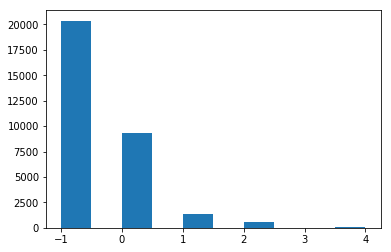

In [58]:
# Explore Distribution of Building Classification
distr_analysis(bldg_classes['Type'].values)

In [59]:
# Def: Graph Building Type over List of Dates
# Param dates (arr): List of dates
# Param types (arr): List of building classification types
# Param bldg_name (str): Name of the Building
# Param show (bool): Plots Graph if True
# Param save (bool): Save Image of Plot 
def graph_bldg_type(dates, types, bldg_name, show=False, save=False):
    fig = plt.figure()
    plt.plot(dates, types)
    plt.title(bldg_name)
    plt.xlabel('Date')
    plt.yticks([-1, 0, 1, 2, 3, 4])
    plt.ylabel('Classification')
    if show: plt.show()
    if save: fig.savefig( bldg_name + '.png', bbox_inches='tight')

In [60]:
# Convert Date String into Matplot Date Object
# Param date (str): In form "MM/DD/YYYY"
from matplotlib import dates as mpl_dates
def convert_to_matplot_date(date_x):
    date_elem = date_x.split('/')
    python_date = date(int(date_elem[2]), int(date_elem[0]), int(date_elem[1]))
    matplot_date = mpl_dates.date2num(python_date)
    return matplot_date

In [61]:
# Plot Building Types over Time Given a Dataframe with the Columns: 'Building', 'Data', 'Type'
# param bldg_df (dataframe): dataframe with the building data
# return bldg_classes [bldg label (arr), dates (arr), types(arr)]
def table_bldg_classes(bldg_df):
    counter = 0
    # Arrays for Dataframe Creation
    bldgs_labels = []
    dates_arr = []
    types_arr = []
    # Arrays Collect Information for Each Building then Reset for next Building
    prev_bldg = bldg_df['Building'][0]
    dates = []
    bldg_type = []
    for i in range(len(bldg_df)):    
        curr_bldg = bldg_df['Building'][i]
        # Graph Old Building if Current Bldg is New or Last Bldg
        if curr_bldg != prev_bldg or i == len(bldg_df):
            counter += 1
            bldgs_labels.append(prev_bldg)
            dates_arr.append(dates)
            types_arr.append(bldg_type)
            dates = []
            bldg_type = []
            prev_bldg = curr_bldg
        else:
            dates.append(bldg_df['Date'][i])
            bldg_type.append(bldg_df['Type'][i])
    print(counter)
    return [bldgs_labels, dates_arr, types_arr]

In [62]:
# Plot Building Types over Time Given a Dataframe with the Columns: 'Building', 'Data', 'Type'
# param bldg_arr (arr): [ bldg(arr), array of dates (arr), array of types (arr)]
# param show (bool): Displays Plot
# param save (bool): Saves plot to the current directory
def plot_building_type(bldg_arr, show=True, save=False):
    for i in range(len(bldg_arr[0])):
        #graph_bldg_type(dates, types, bldg_name, show, save)
        graph_bldg_type(bldg_arr[1][i], bldg_arr[2][i], bldg_arr[0][i], show=show, save=save)

In [63]:
#plot_building_type(wkday_bldg_arr, show=True, save=False)

In [64]:
len(table_bldg_classes(wkday_bldg)[1][0])

133


159

### Entropy-Based Ranking

In [65]:
# data (arr or series) - Pandas series to calculate entropy
# Uses Boltzmann's Entropy
def entropy(data):
    data = pd.Series(data)
    p_data= data.value_counts()/len(data) # calculates the probabilities
    entropy=sc.stats.entropy(p_data)  # input probabilities to get the entropy 
    return entropy

In [66]:
# data  (arr) - Bldg Classification Arrays (2D Array)
# entropy (arr) - Entropy Scores
def entropy_list(data):
    scores = []
    for bldg_types in data:
        data_series = pd.Series(bldg_types)
        print(entropy(data_series))
        scores.append(entropy(data_series))
    return scores

In [67]:
import scipy as sc
wkday_bldg_arr = table_bldg_classes(wkday_bldg)
entropy_scores = entropy_list(wkday_bldg_arr[2])

133
0.0
0.03835078340871136
0.0678872387735005
0.0
0.0
0.0
0.0
0.4977822019945046
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.14041660558890898
0.0
0.0
0.35153050647056067
0.26876309273030147
0.09407142550489367
0.16145328629277475
0.0
0.0
0.0
0.0
0.0
0.13230049101618696
0.0
0.0
0.4534779906550221
1.273302283016011
0.0
1.0848192174296716
0.0
0.0
0.8660642833619213
0.6478295356523749
0.0
0.0
0.4113130750556242
1.30694814766752
0.0
0.10615713756112428
0.0
0.11493115250492104
0.8344078812970357
0.0
0.0
0.0
0.03835078340871136
0.0
0.0
0.0
0.0
0.0
0.0
0.03835078340871136
0.49509273353784894
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.23592878336222323
0.0
0.0
0.0678872387735005
0.13230049101618696
0.09407142550489367
0.0
0.0
0.0
0.0
0.6608297500025779
0.0
0.5725266462787764
0.0
0.0
0.8539662910601896
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.20037461247078298
0.0
0.03835078340871136
0.0
0.5524041823179927
0.0
0.18138853680898728
0.6795459060506643
0.0
0.0
0.0
0.0
0.0
0.0
0.6881727702227625
0.0
0.7885065980364792
0.1562521

In [68]:
# Graph Entropy Scores
# param scores (arr) - List of Entropy Scores
def graph_entropy_scores(scores):
    plt.title('Entropy of Building Classifications')
    plt.xlabel('Bldgs')
    plt.ylabel('Entropy')
    plt.plot(entropy_scores)
    plt.show()

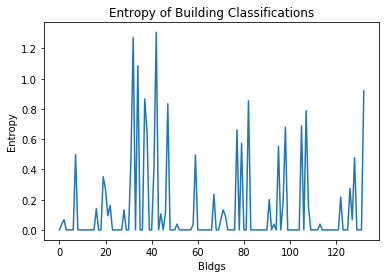

In [69]:
graph_entropy_scores(entropy_scores)

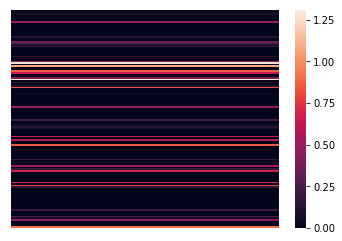

In [70]:
import seaborn as sns
ax = sns.heatmap(pd.DataFrame(entropy_scores), yticklabels=False, xticklabels=False)

In [71]:
# Sort Building by Entropy
# param bldgs (arr) - Building Names
# param entr (arr) - Associated Entropy Scores
# return bldgs, entr - Sorted Lists
def entropy_sort(bldgs, entr):
    bldgs, entr = bldgs, entr
    if(len(bldgs) != len(entr)):
        print('Building and Entropy Array Must be The Same Length')
        return
    for passnum in range(len(entr)-1,0,-1):
        for i in range(passnum):
            if entr[i]>entr[i+1]:
                # Swap Entropy Scores in Array
                temp_entr = entr[i]
                entr[i] = entr[i+1]
                entr[i+1] = temp_entr
                # Swap Bldg Names in Array
                temp_bldg = bldgs[i]
                bldgs[i] = bldgs[i+1]
                bldgs[i+1] = temp_bldg
    return bldgs, entr

In [72]:
import copy
bldg_names = copy.deepcopy(wkday_bldg_arr[0])
# Sort Buildings And Associated Entropy
bldgs_sorted, entr_sorted = entropy_sort(bldg_names, entropy_scores)

In [73]:
for i in range(len(bldgs_sorted)):
    print(bldgs_sorted[i])
    print(entr_sorted[i])

B101
0.0
B107
0.0
B108
0.0
B109
0.0
B110
0.0
B114
0.0
B115
0.0
B116
0.0
B117
0.0
B118
0.0
B119
0.0
B123
0.0
B124
0.0
B129
0.0
B130
0.0
B138
0.0
B139
0.0
B141
0.0
B144
0.0
B145
0.0
B147
0.0
B148
0.0
B152
0.0
B155
0.0
B158
0.0
B165
0.0
B167
0.0
B177
0.0
B181
0.0
B189
0.0
B196
0.0
B199
0.0
B203
0.0
B302
0.0
B318
0.0
B320
0.0
B336
0.0
B362
0.0
B003
0.0
B006
0.0
B007
0.0
B008
0.0
B009
0.0
B010
0.0
B011
0.0
B013
0.0
B014
0.0
B020
0.0
B022
0.0
B024
0.0
B025
0.0
B029
0.0
B031
0.0
B032
0.0
B035
0.0
B036
0.0
B038
0.0
B039
0.0
B040
0.0
B041
0.0
B045
0.0
B046
0.0
B050
0.0
B051
0.0
B054
0.0
B058
0.0
B059
0.0
B061
0.0
B064
0.0
B065
0.0
B066
0.0
B071
0.0
B075
0.0
B076
0.0
B081
0.0
B084
0.0
B086
0.0
B090
0.0
B091
0.0
B092
0.0
B093
0.0
B094
0.0
B095
0.0
B098
0.0
B033B
0.0
B051D
0.0
B051F
0.0
B060A
0.0
B061A
0.0
B080A
0.0
B103
0.03835078340871136
B200
0.03835078340871136
B790
0.03835078340871136
B051W
0.03835078340871136
B085
0.03835078340871136
B104
0.0678872387735005
B015
0.0678872387735005
B051F_C2
0

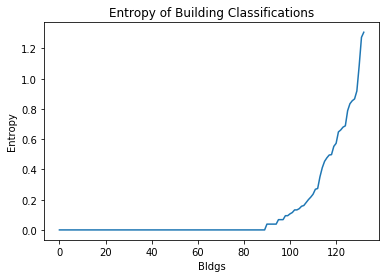

In [74]:
graph_entropy_scores(entr_sorted)

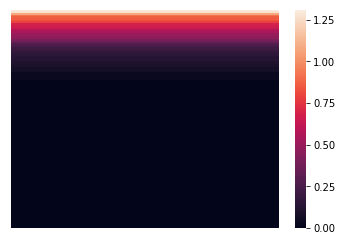

In [75]:
ax = sns.heatmap(pd.DataFrame(entr_sorted[::-1]), yticklabels=False, xticklabels=False)

#### Cumulative Entropy over Time

In [76]:
# Calculate Cumulative Entropy of Building Classifications Over Time
# param bldg_arr (arr): [[bldg_names], [date], [classification]]
# returns bldg_entr_over_t (arr) Array of Bldg Cumulative Entropy Arrays for each bldg
def cum_entropy(bldg_arr):
    bldg_entr_over_t = []
    for i in range(0, len(bldg_arr[0])):
        entr_over_t = []
        for j in range(1, len(bldg_arr[2][0])):
            entr = entropy(pd.Series(bldg_arr[2][i][:j]))
            entr_over_t.append(entr)
        bldg_entr_over_t.append(entr_over_t)
    return bldg_entr_over_t

In [77]:
wkday_bldg_arr[0]

['B101',
 'B103',
 'B104',
 'B107',
 'B108',
 'B109',
 'B110',
 'B111',
 'B114',
 'B115',
 'B116',
 'B117',
 'B118',
 'B119',
 'B123',
 'B124',
 'B126',
 'B129',
 'B130',
 'B131',
 'B132',
 'B135',
 'B136',
 'B138',
 'B139',
 'B141',
 'B144',
 'B145',
 'B146',
 'B147',
 'B148',
 'B149',
 'B151',
 'B152',
 'B153',
 'B155',
 'B158',
 'B159',
 'B160',
 'B165',
 'B167',
 'B170',
 'B173',
 'B177',
 'B180',
 'B181',
 'B182',
 'B184',
 'B189',
 'B196',
 'B199',
 'B200',
 'B203',
 'B302',
 'B318',
 'B320',
 'B336',
 'B362',
 'B790',
 'B002',
 'B003',
 'B006',
 'B007',
 'B008',
 'B009',
 'B010',
 'B011',
 'B012',
 'B013',
 'B014',
 'B015',
 'B017',
 'B018',
 'B020',
 'B022',
 'B024',
 'B025',
 'B026',
 'B029',
 'B030',
 'B031',
 'B032',
 'B033',
 'B035',
 'B036',
 'B038',
 'B039',
 'B040',
 'B041',
 'B045',
 'B046',
 'B047',
 'B050',
 'B051W',
 'B051',
 'B052',
 'B054',
 'B056',
 'B057',
 'B058',
 'B059',
 'B061',
 'B064',
 'B065',
 'B066',
 'B068',
 'B071',
 'B073',
 'B074',
 'B075',
 'B076',


In [78]:
bldg_entr_over_t = cum_entropy(wkday_bldg_arr)

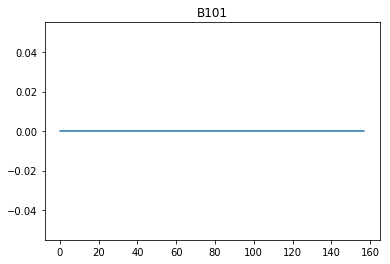

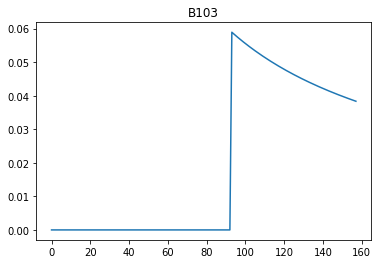

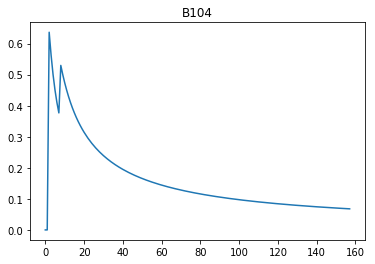

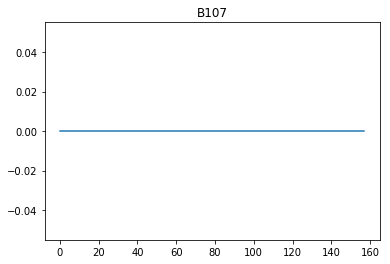

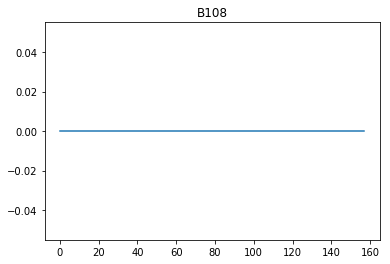

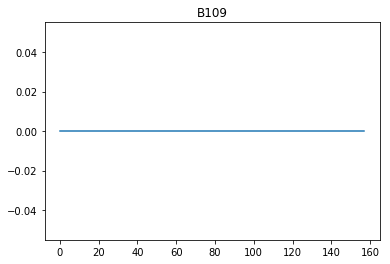

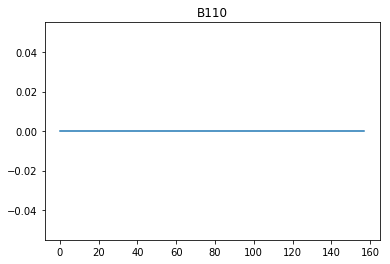

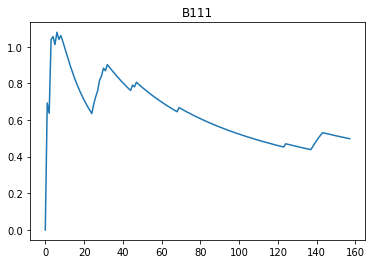

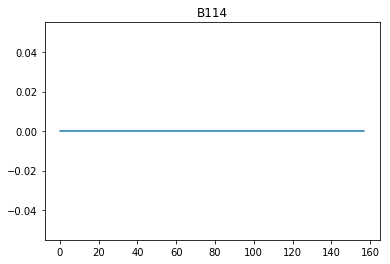

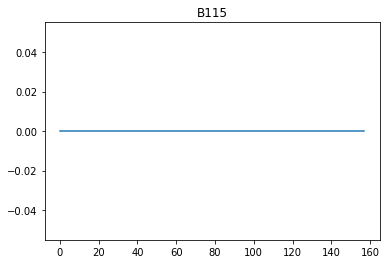

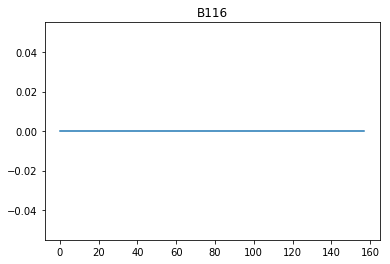

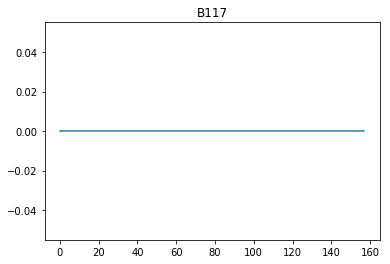

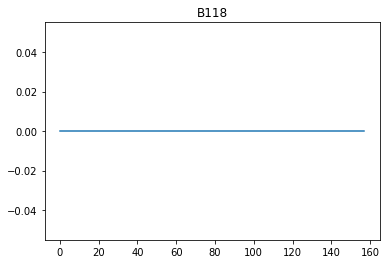

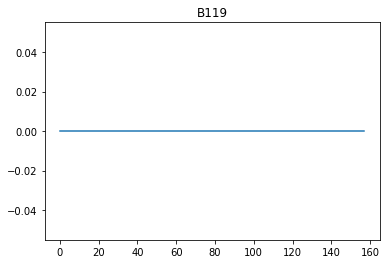

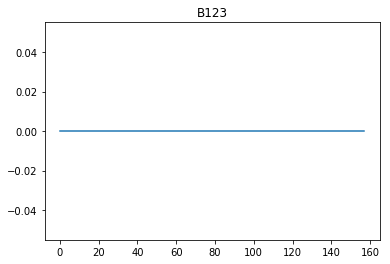

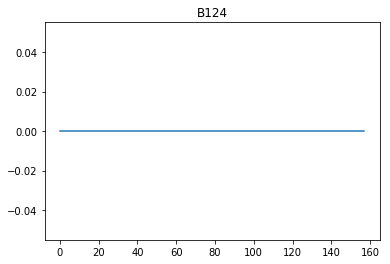

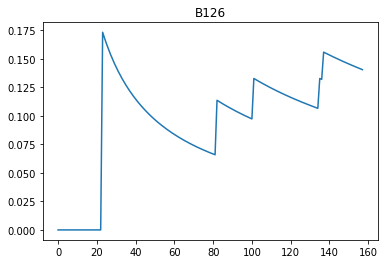

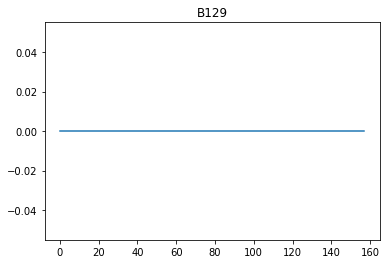

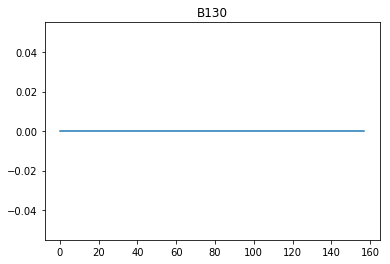

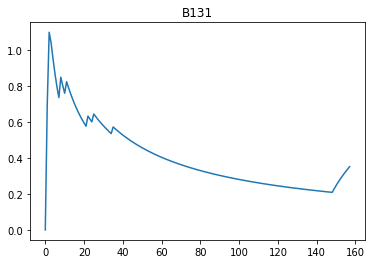

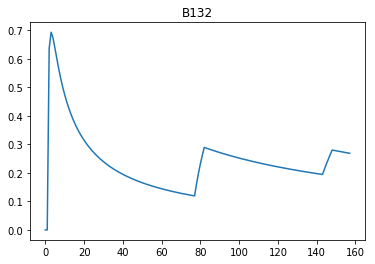

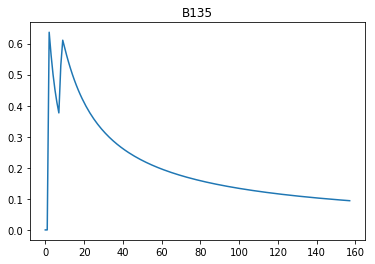

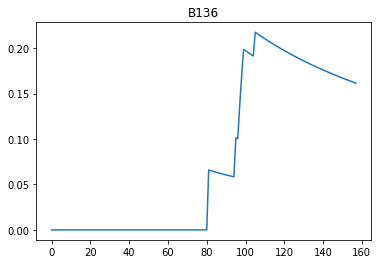

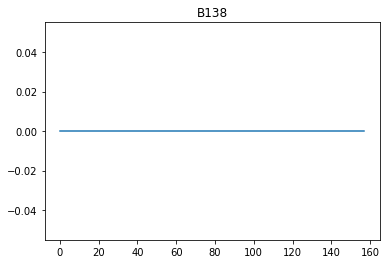

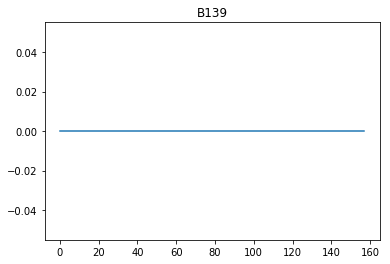

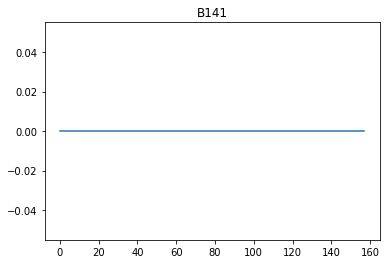

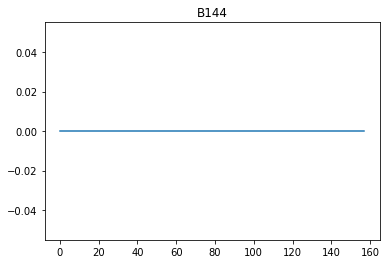

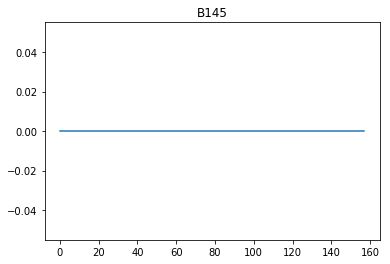

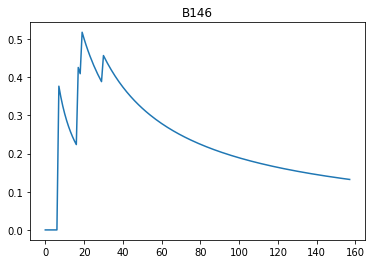

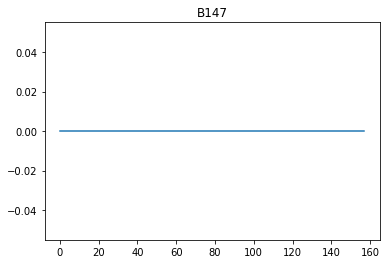

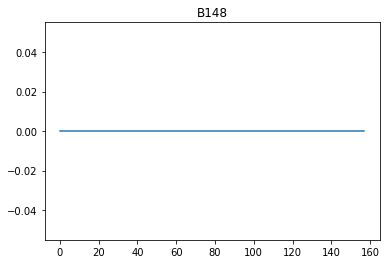

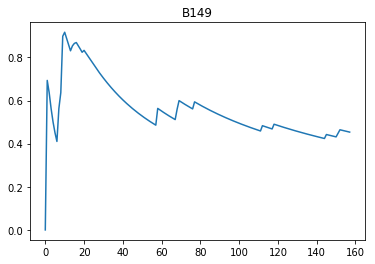

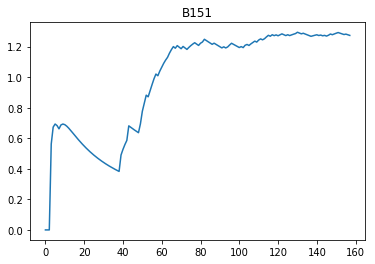

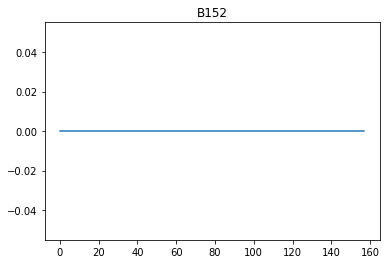

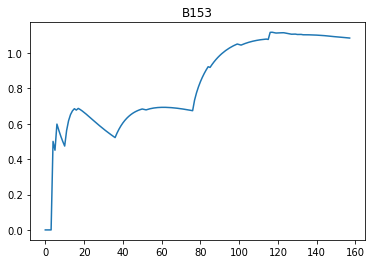

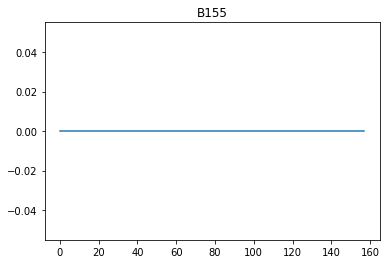

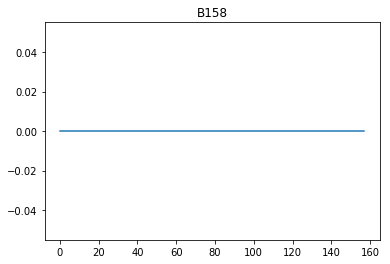

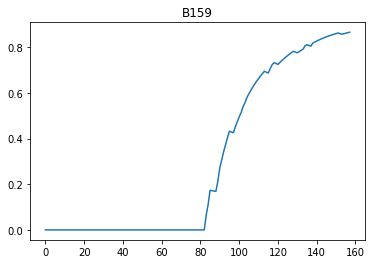

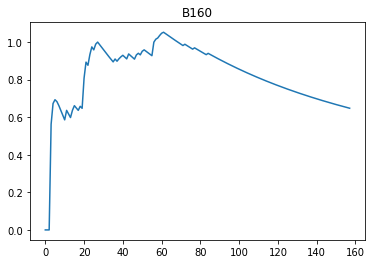

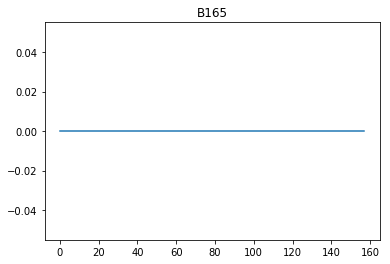

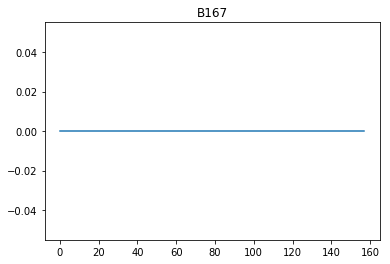

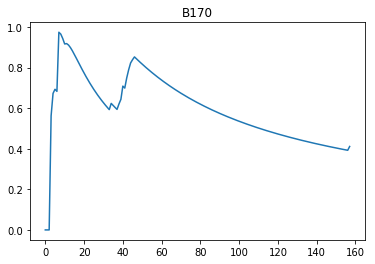

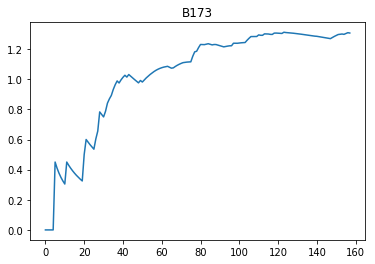

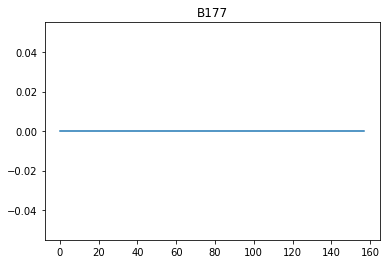

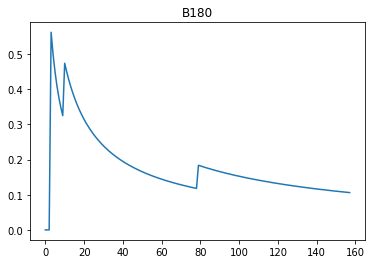

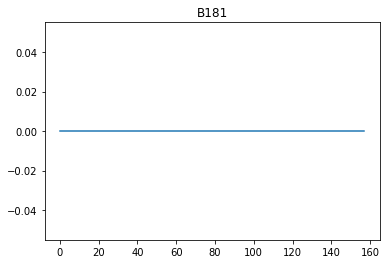

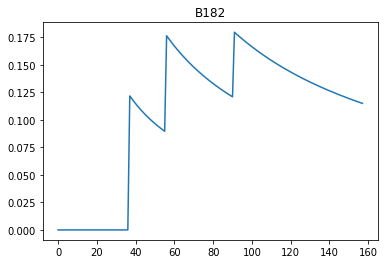

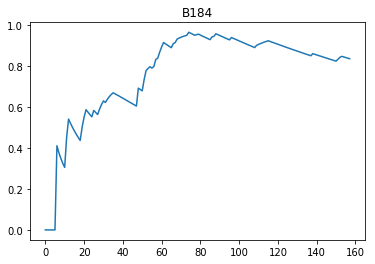

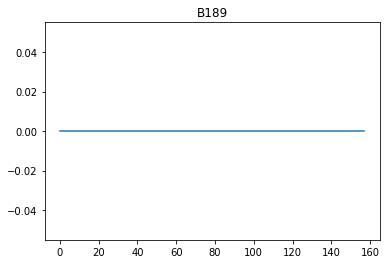

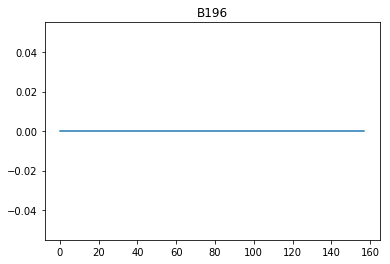

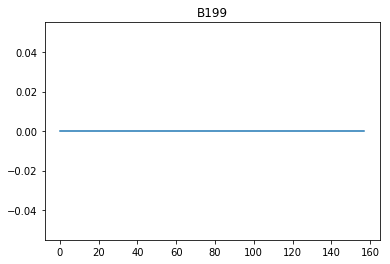

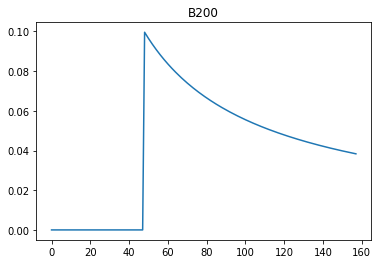

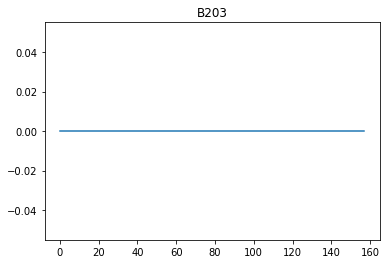

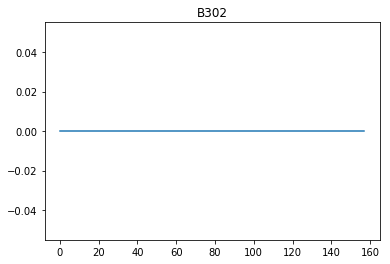

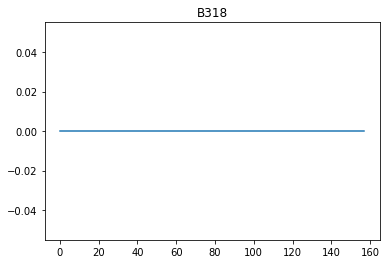

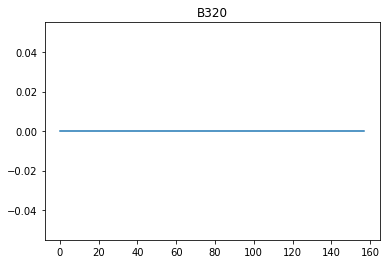

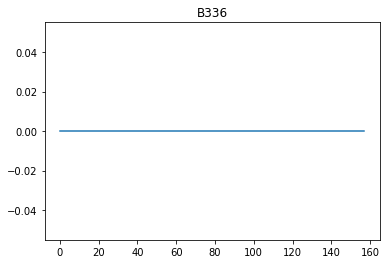

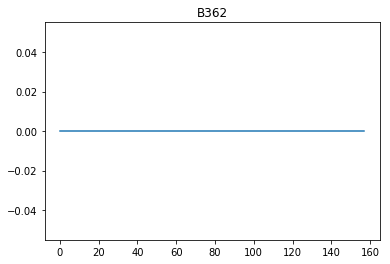

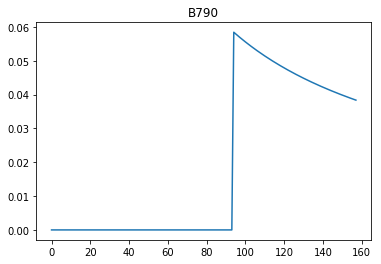

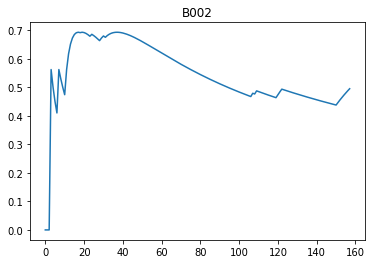

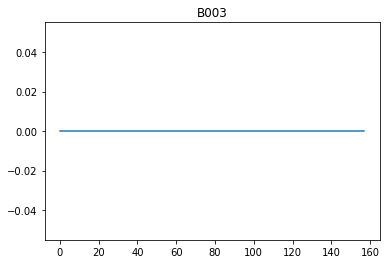

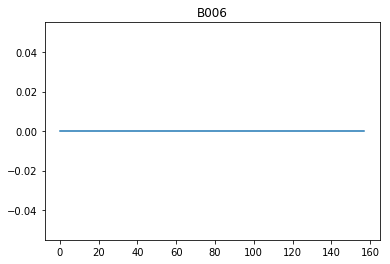

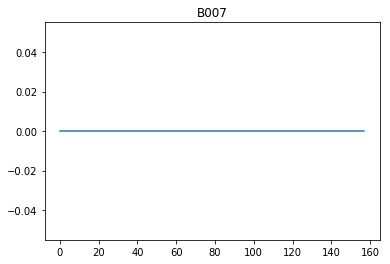

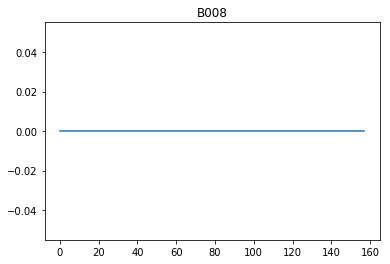

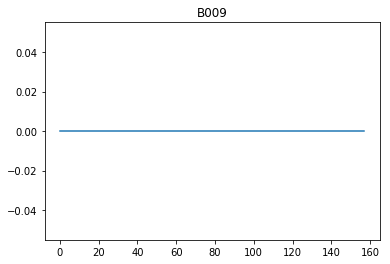

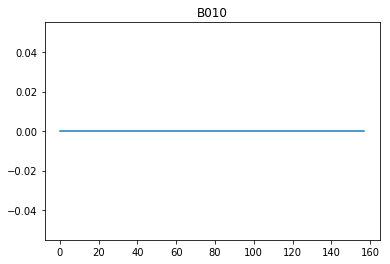

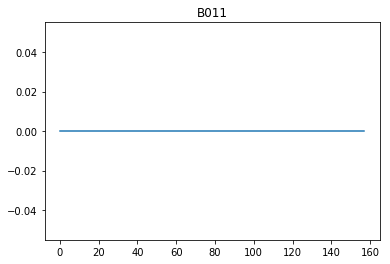

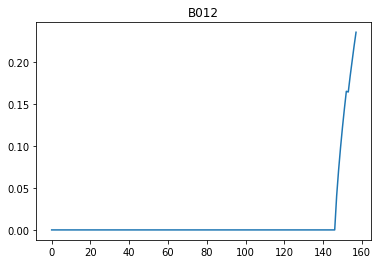

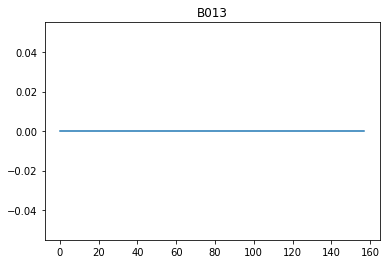

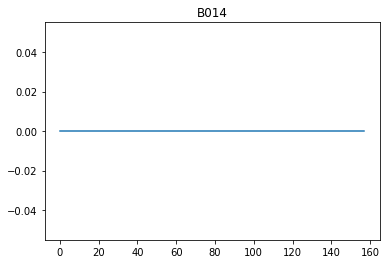

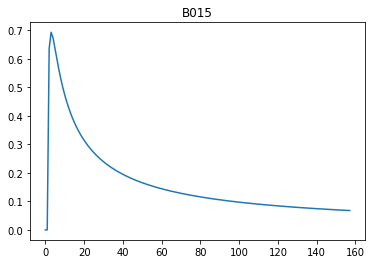

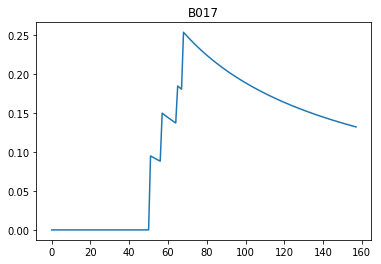

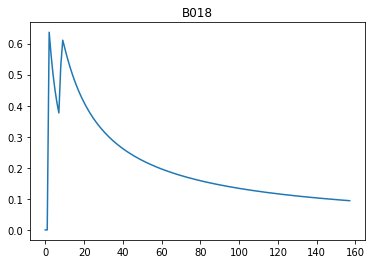

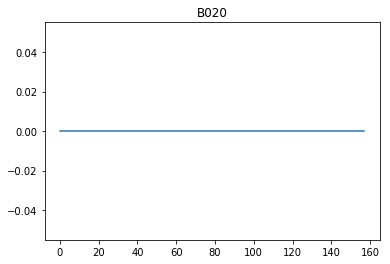

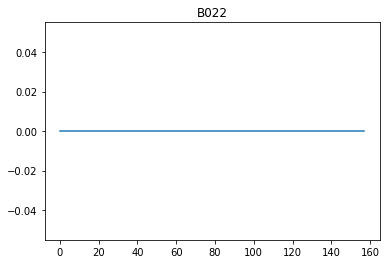

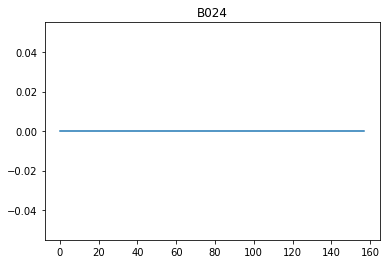

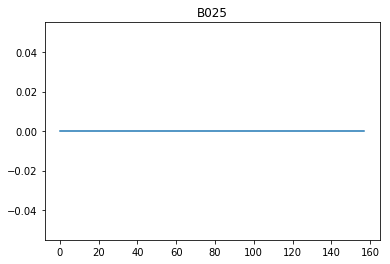

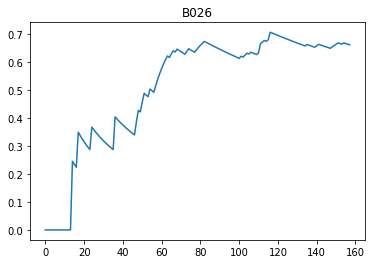

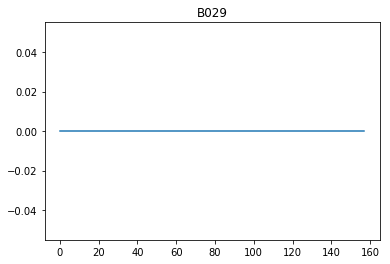

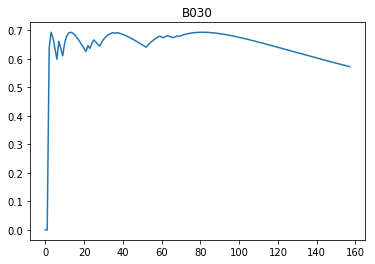

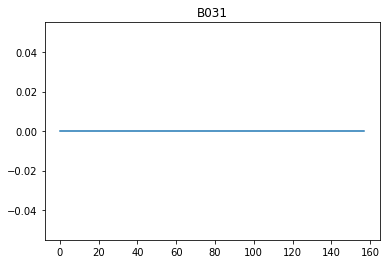

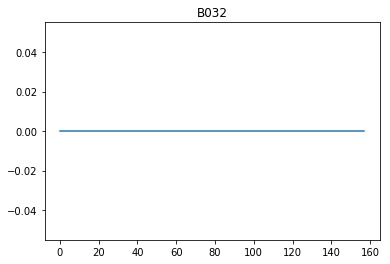

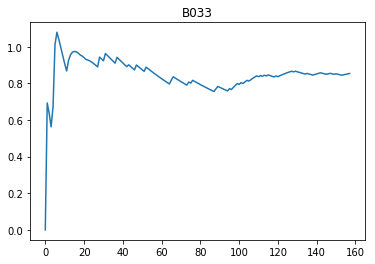

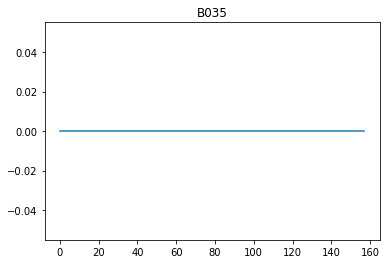

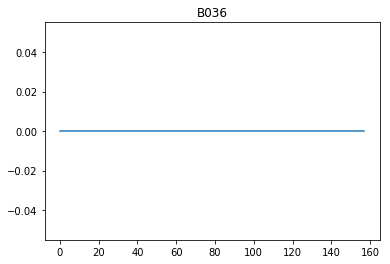

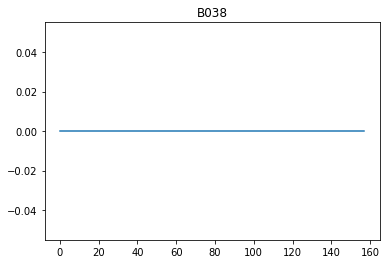

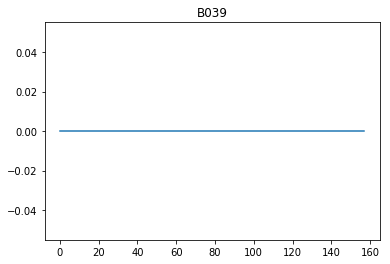

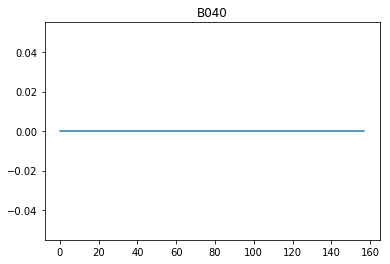

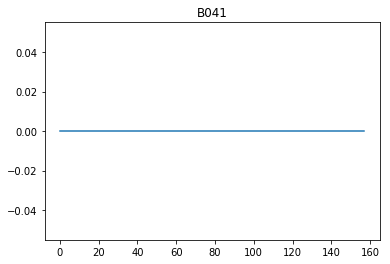

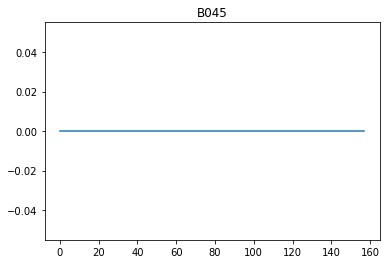

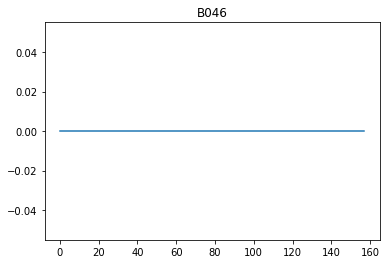

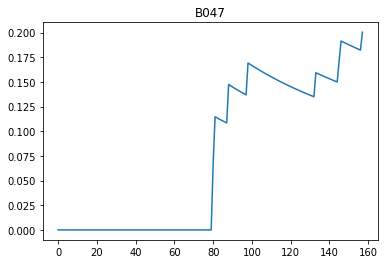

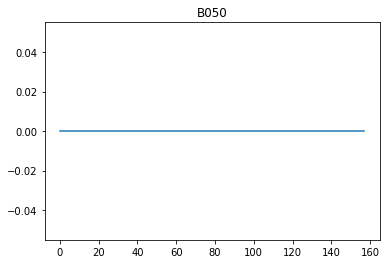

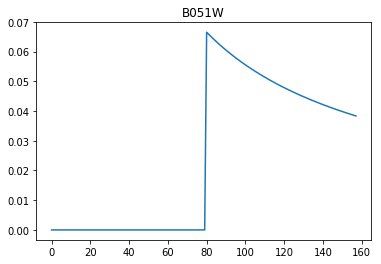

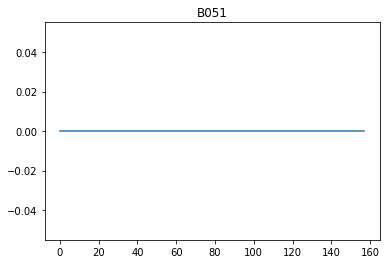

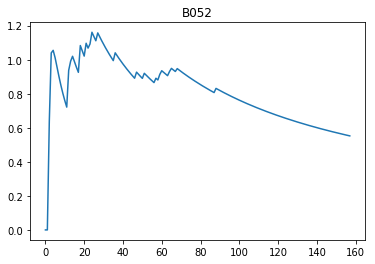

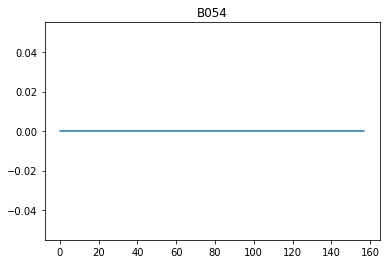

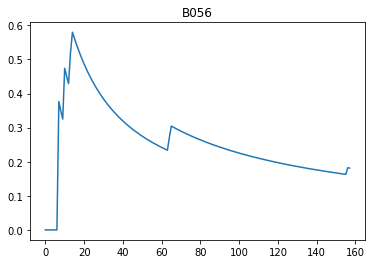

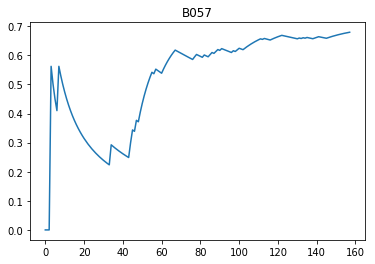

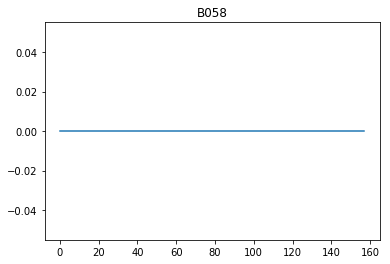

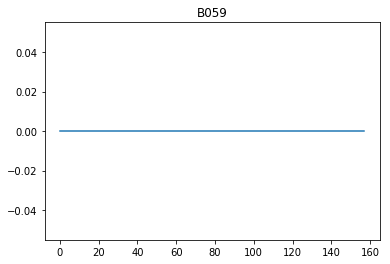

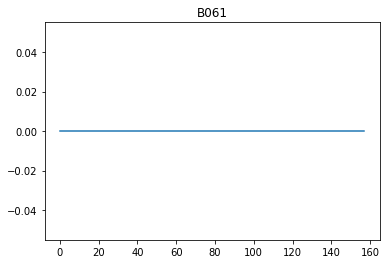

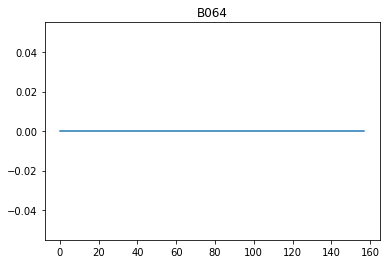

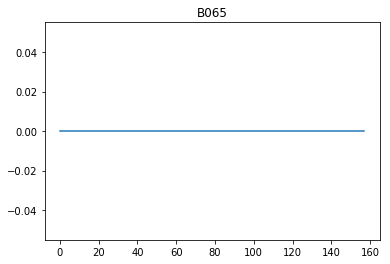

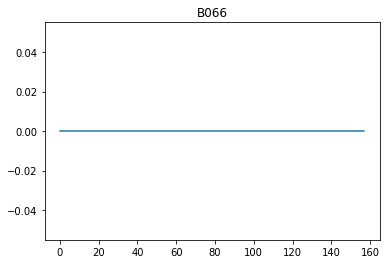

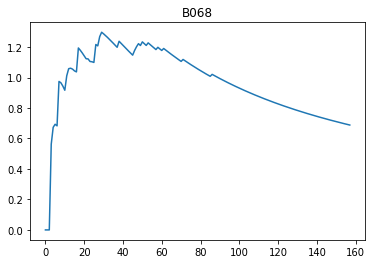

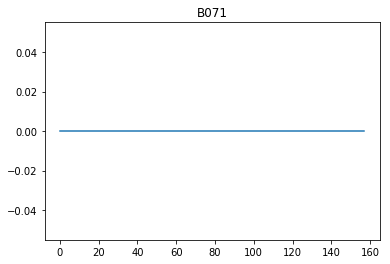

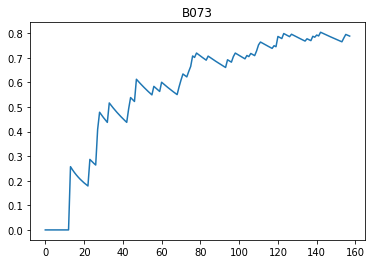

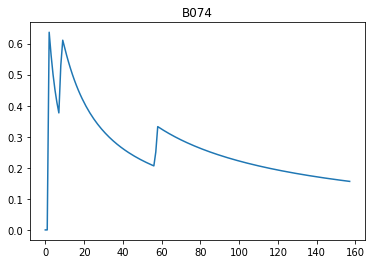

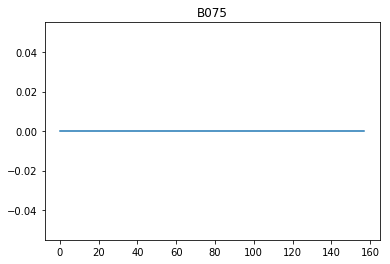

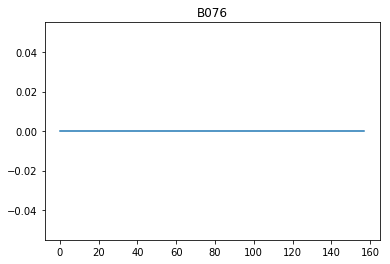

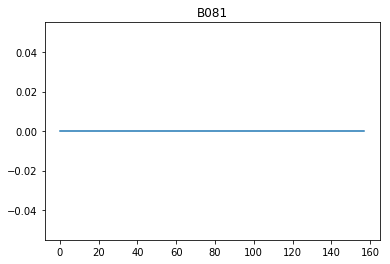

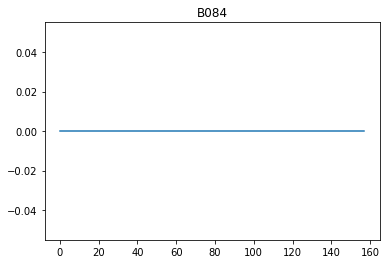

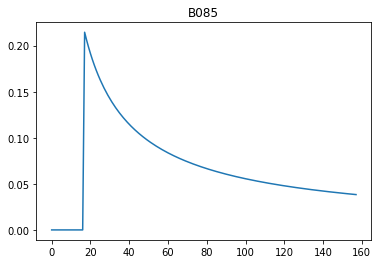

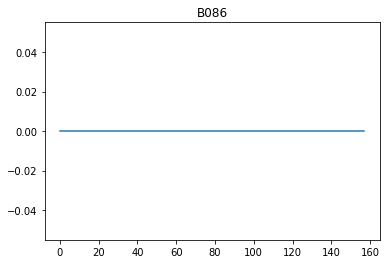

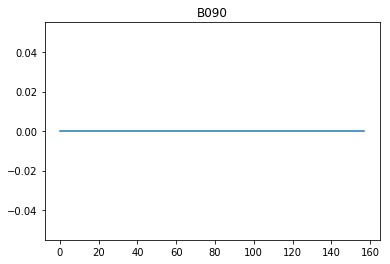

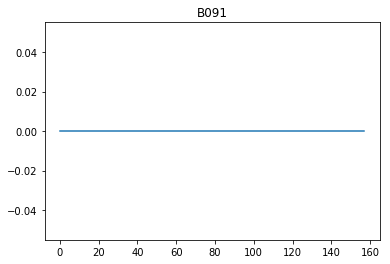

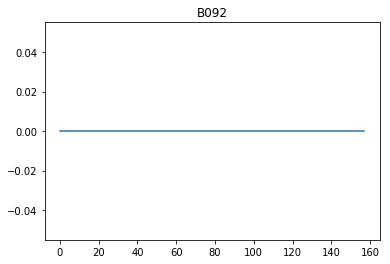

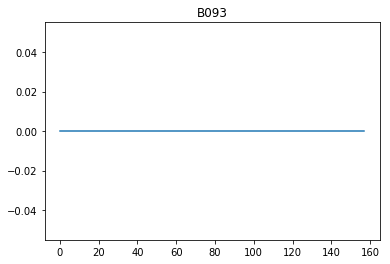

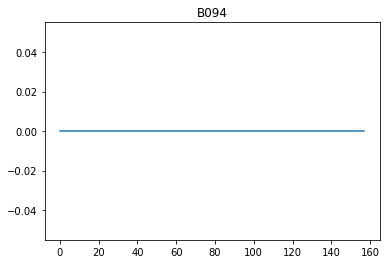

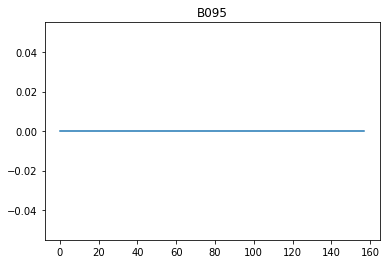

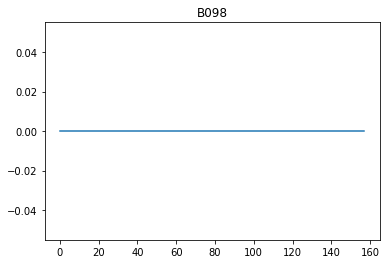

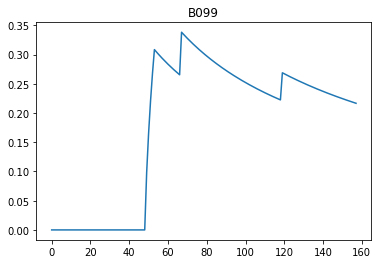

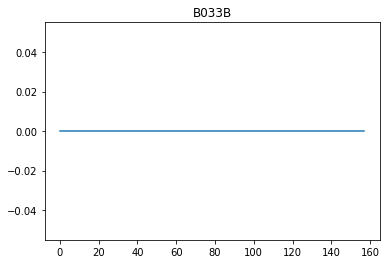

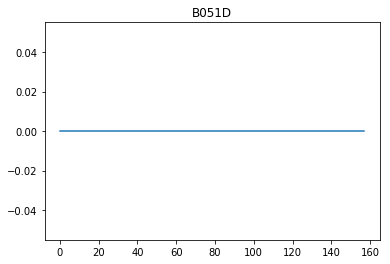

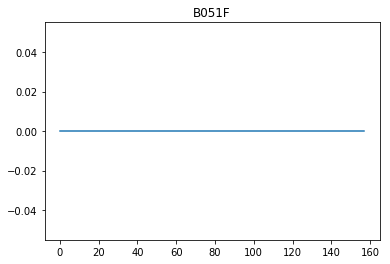

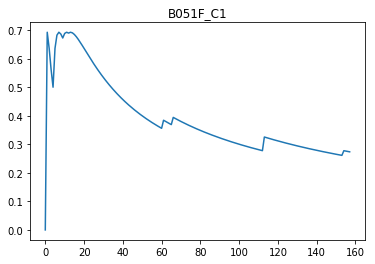

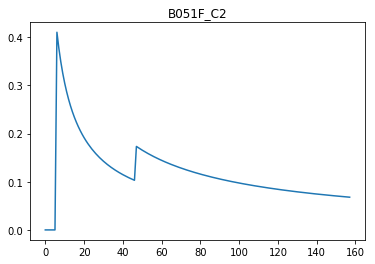

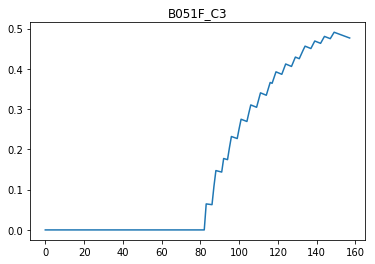

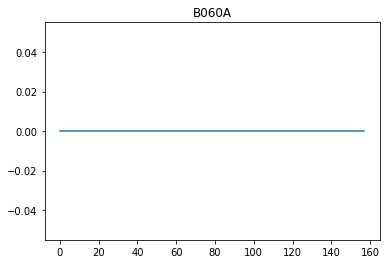

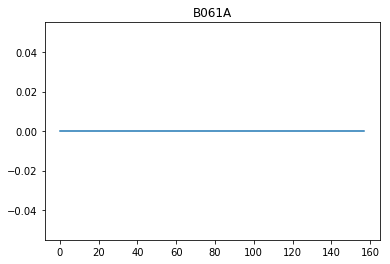

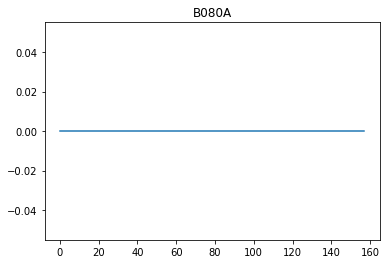

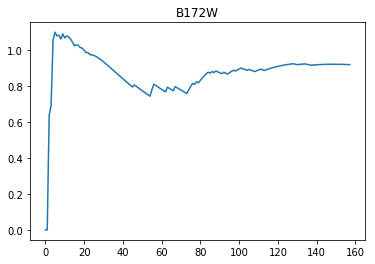

In [79]:
for i in range(0, len(wkday_bldg_arr[0])):
    plt.title(wkday_bldg_arr[0][i])
    plt.plot(bldg_entr_over_t[i])
    plt.show()

#### Sliding Window - Entropy over Time

In [80]:
# Calculate Sliding Window Entropy of Building Classifications Over Time
# param bldg_arr (arr): [[bldg_names], [date], [classification]]
# param window_size (int): Size of Window
# returns bldg_entr_over_t (arr) Array of Bldg Cumulative Entropy Arrays for each bldg
def sliding_entropy(bldg_arr, window=14):
    bldg_entr_over_t_slide = []
    for i in range(0, len(wkday_bldg_arr[0])):
        entr_over_t = []
        for j in range(1, len(wkday_bldg_arr[2][0]) - window):
            entr = entropy(pd.Series(wkday_bldg_arr[2][i][j:j + window]))
            entr_over_t.append(entr)
        bldg_entr_over_t_slide.append(entr_over_t)
    return bldg_entr_over_t_slide

In [90]:
bldg_entr_over_t_slide = sliding_entropy(wkday_bldg_arr, window=28)

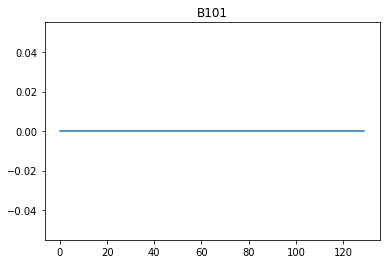

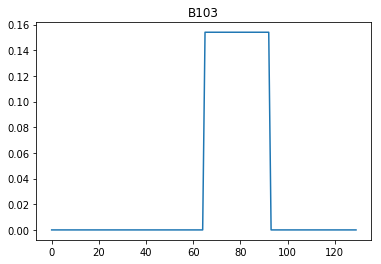

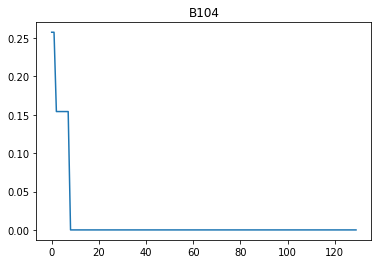

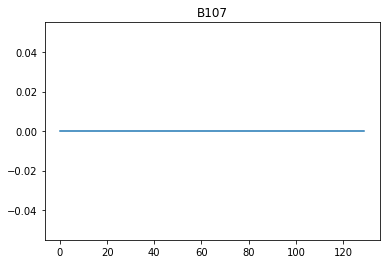

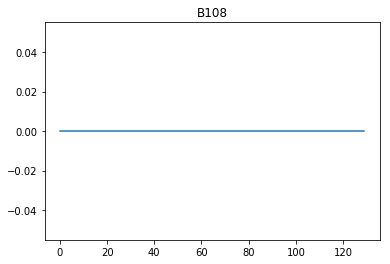

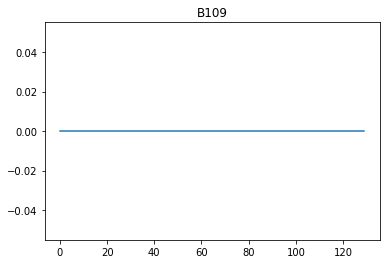

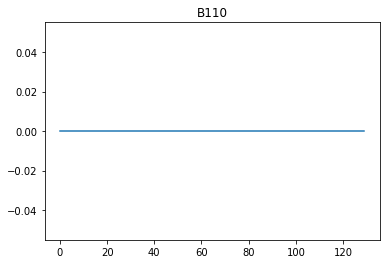

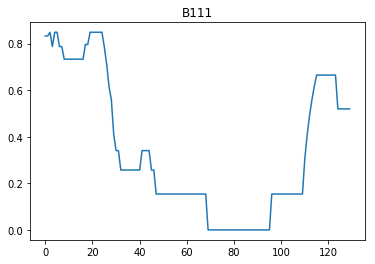

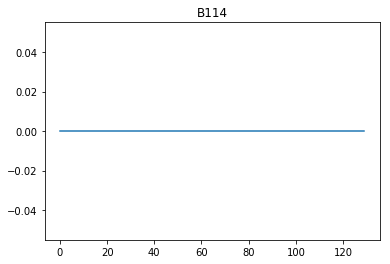

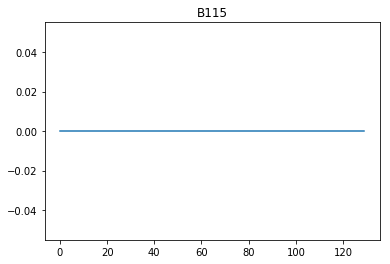

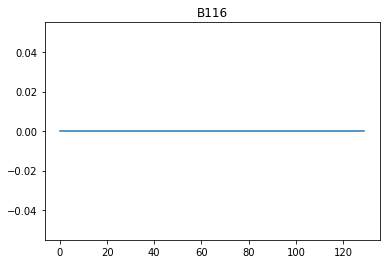

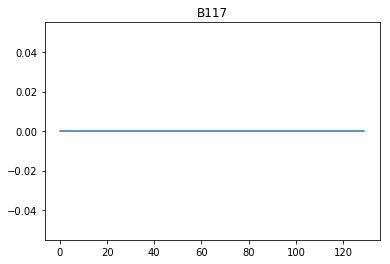

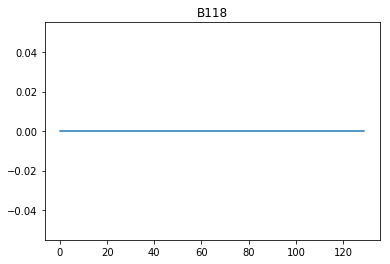

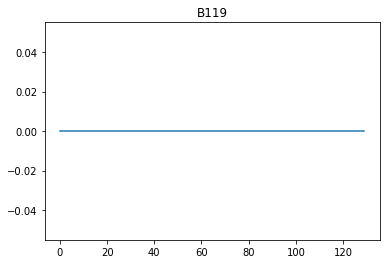

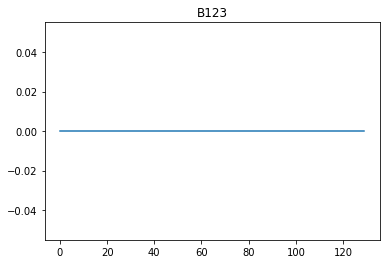

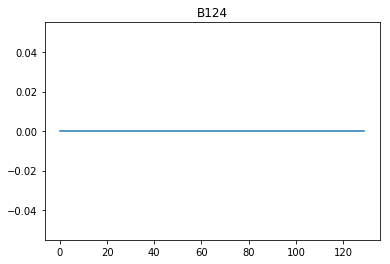

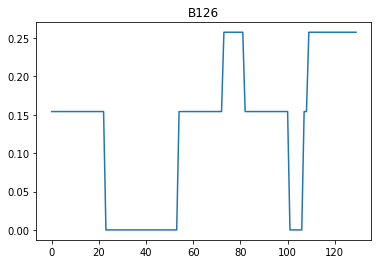

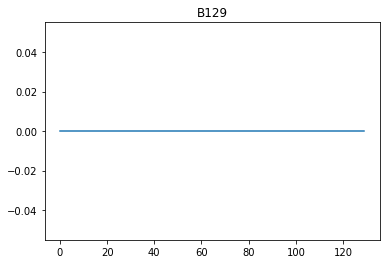

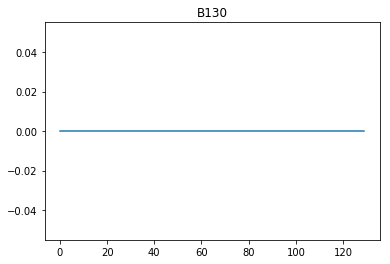

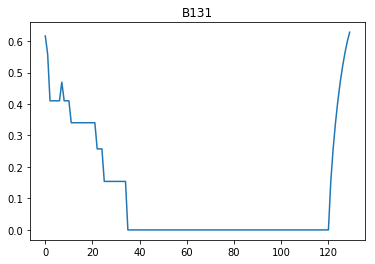

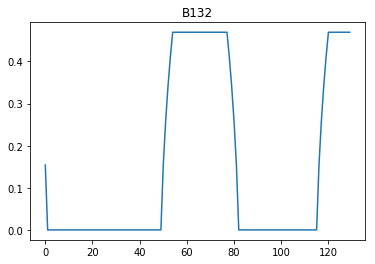

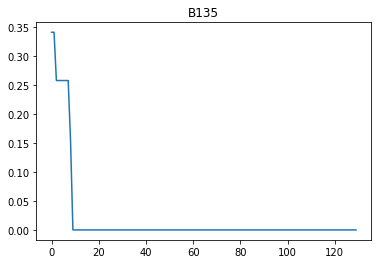

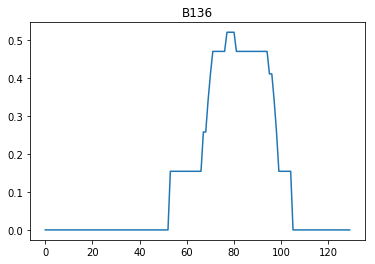

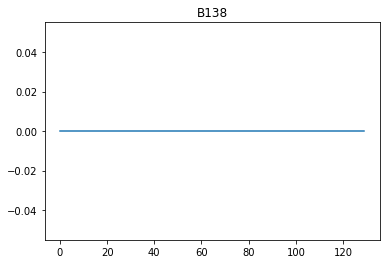

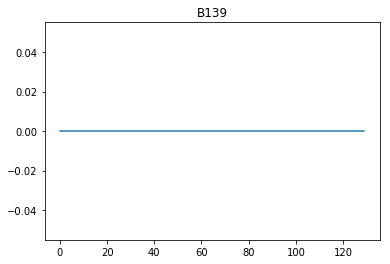

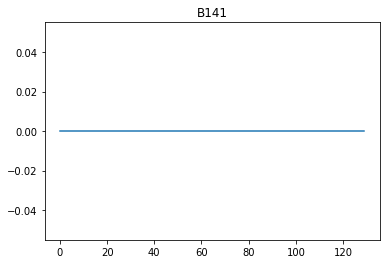

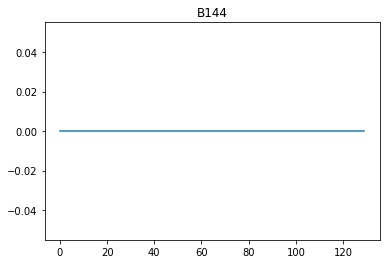

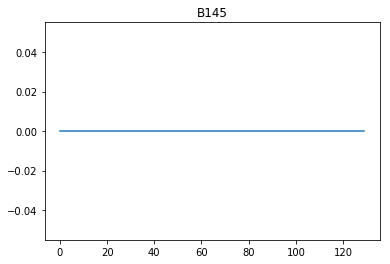

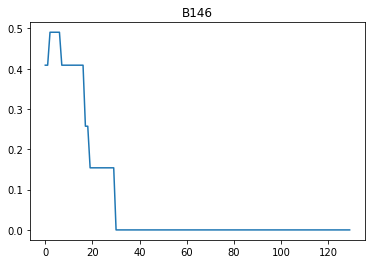

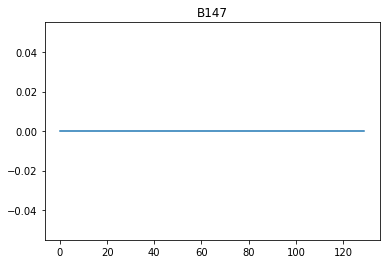

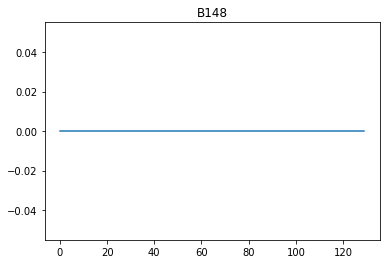

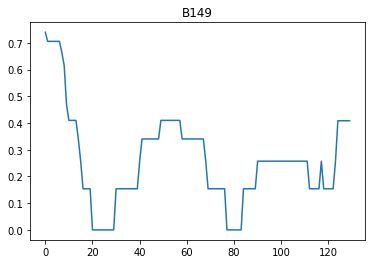

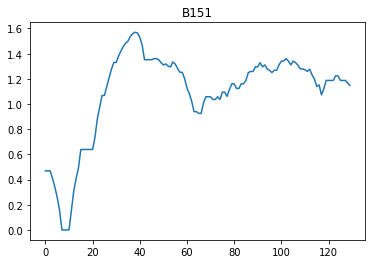

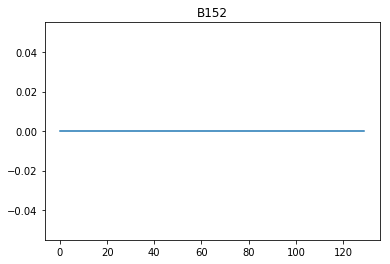

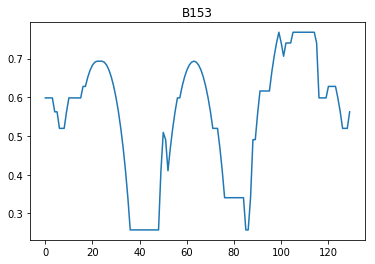

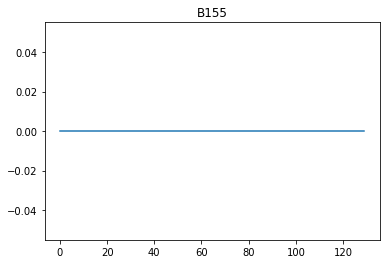

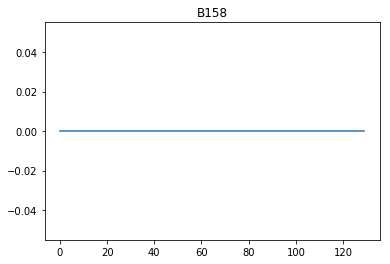

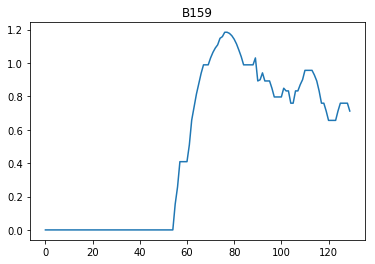

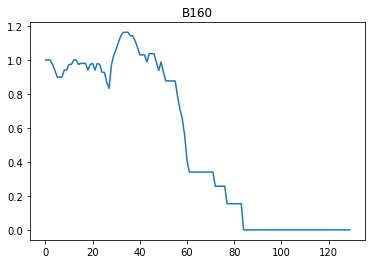

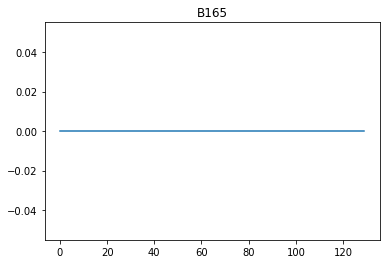

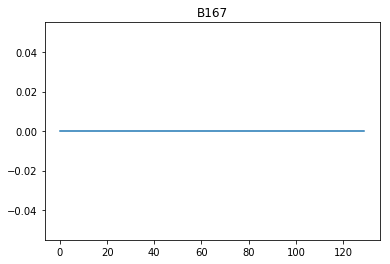

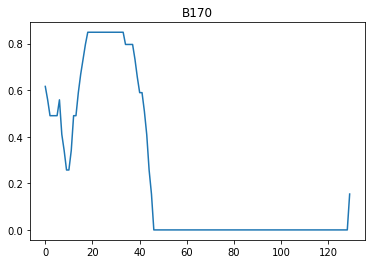

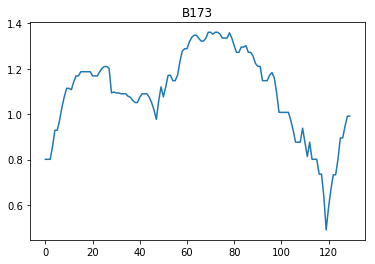

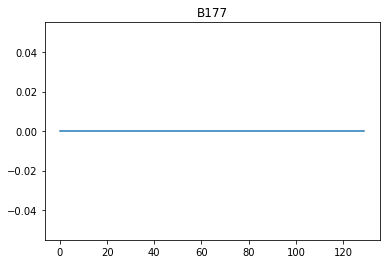

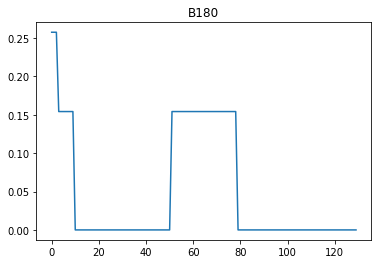

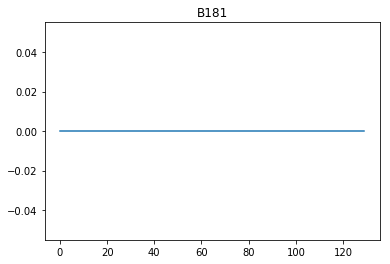

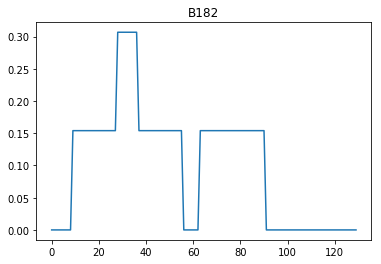

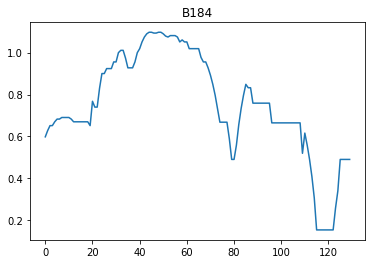

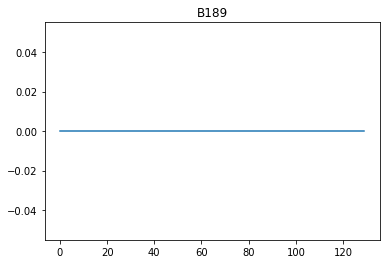

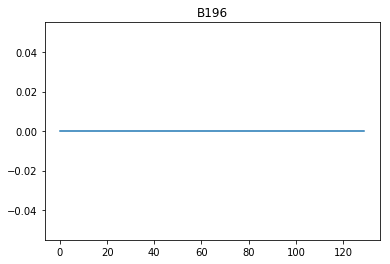

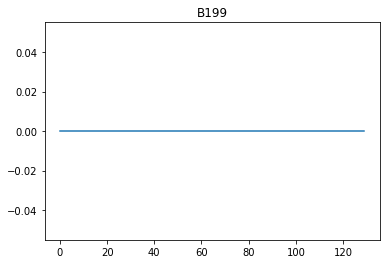

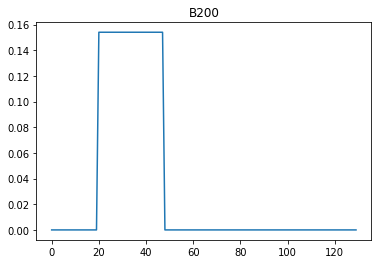

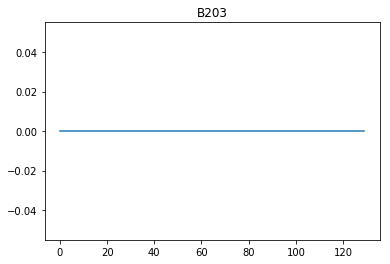

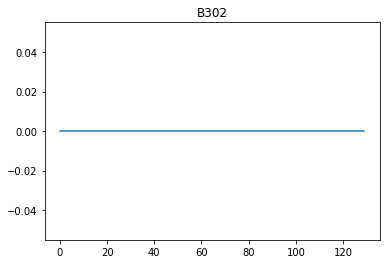

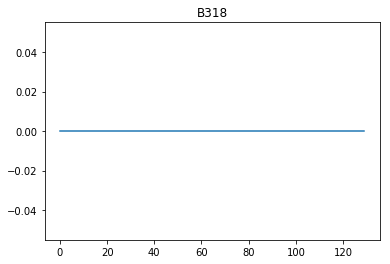

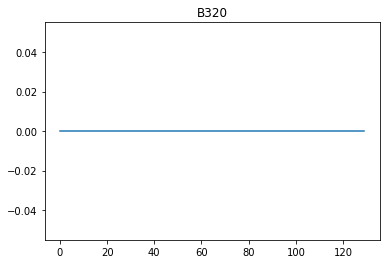

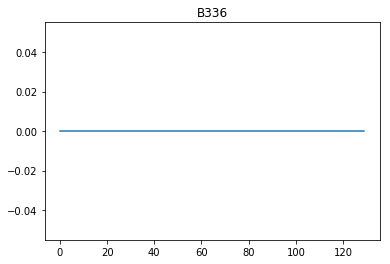

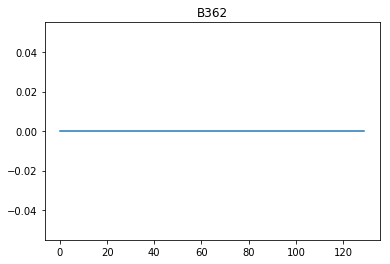

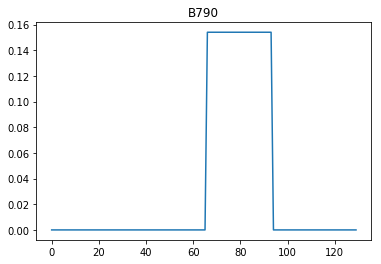

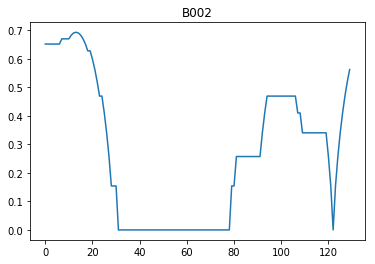

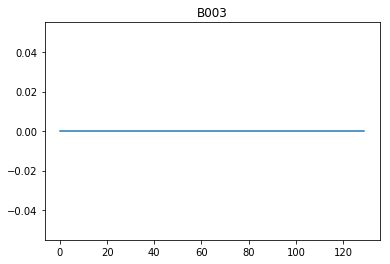

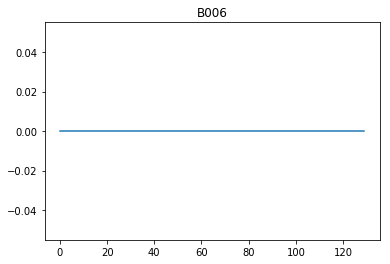

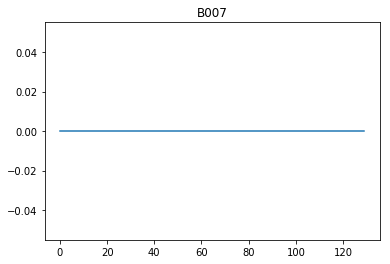

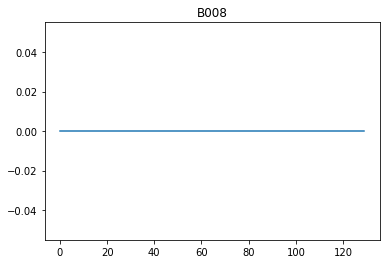

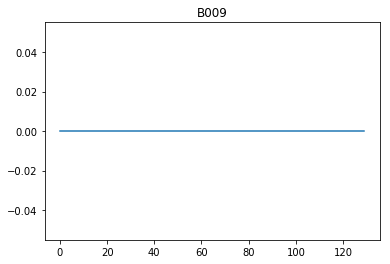

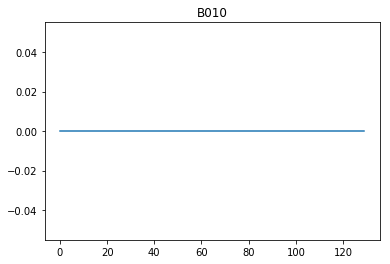

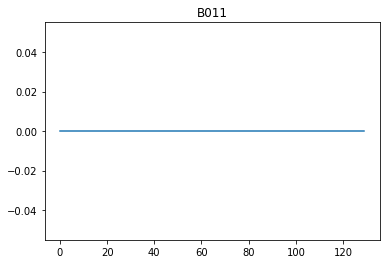

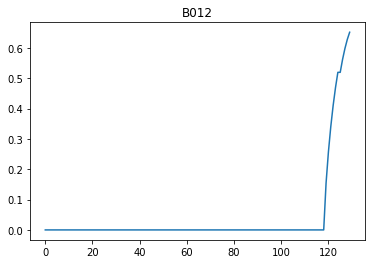

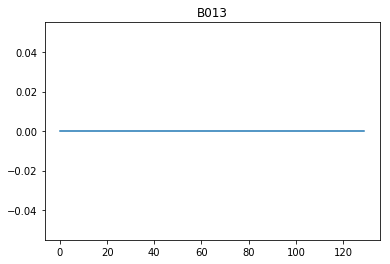

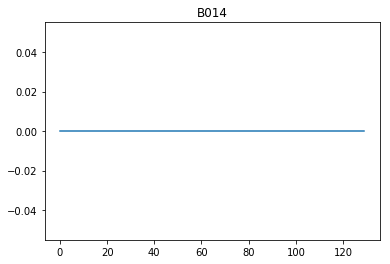

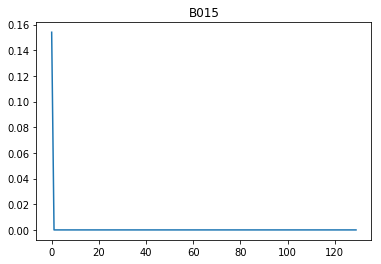

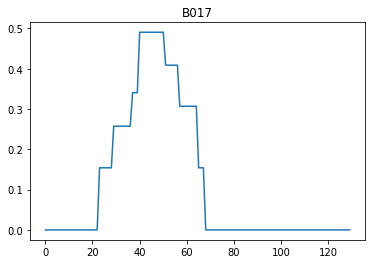

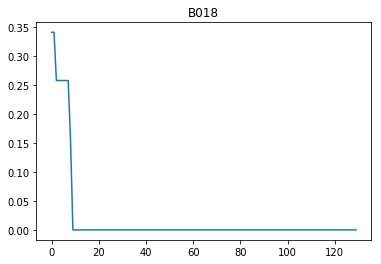

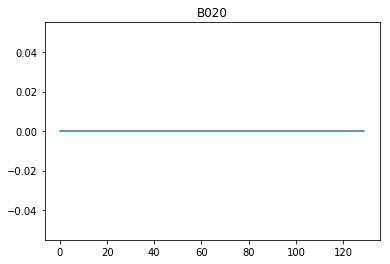

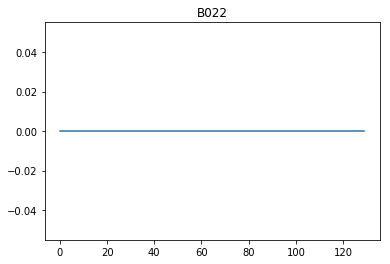

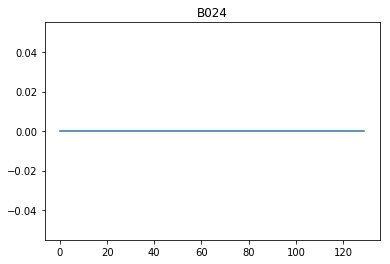

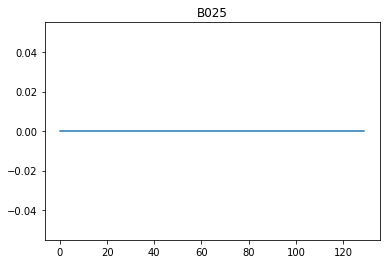

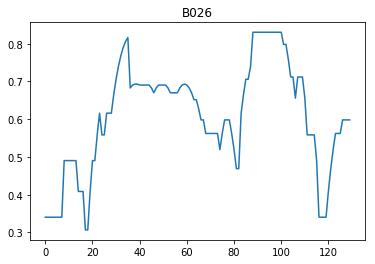

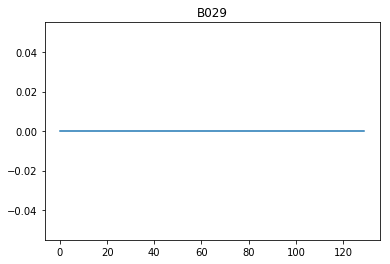

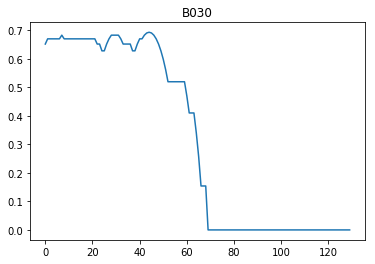

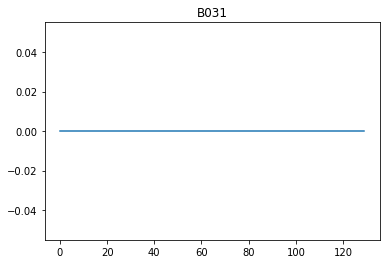

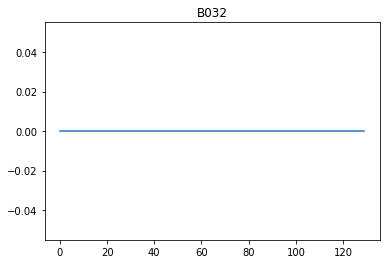

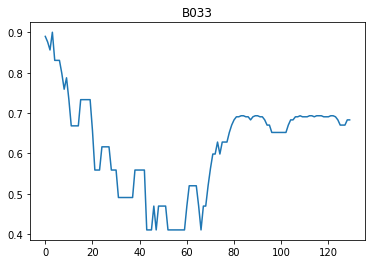

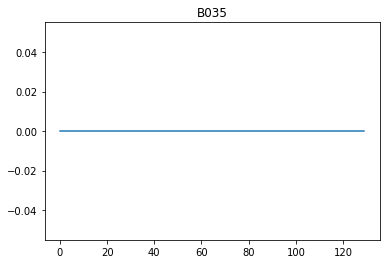

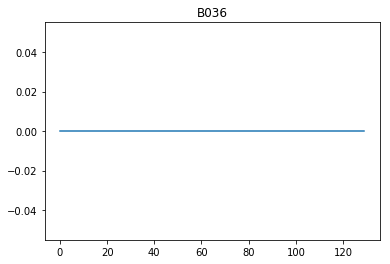

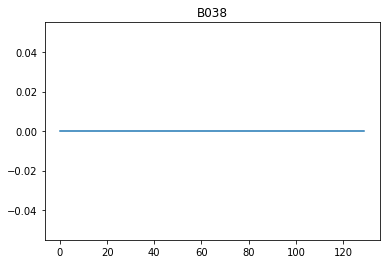

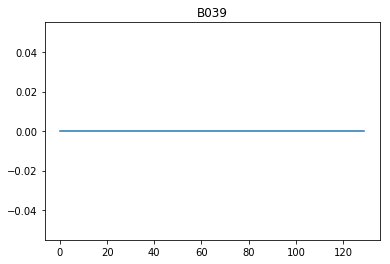

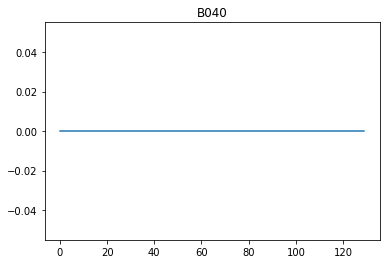

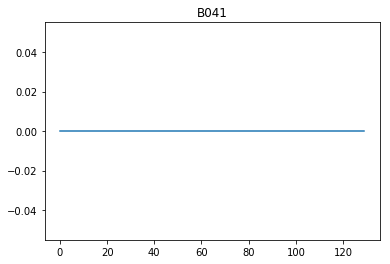

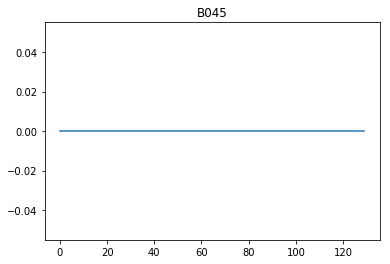

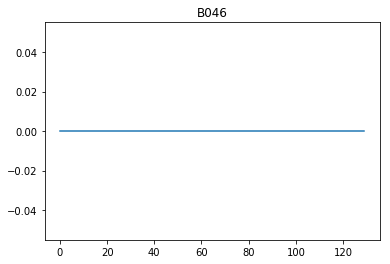

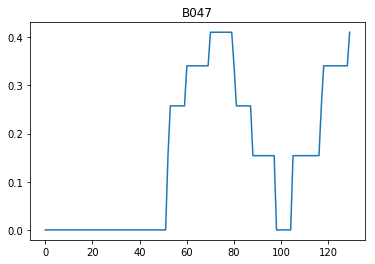

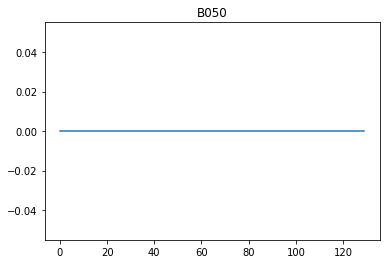

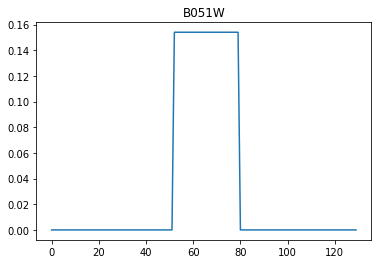

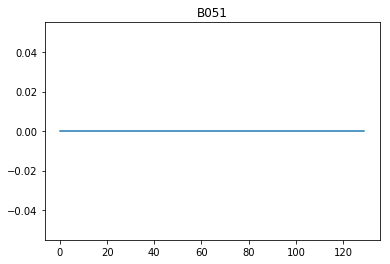

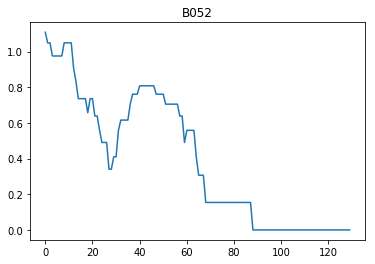

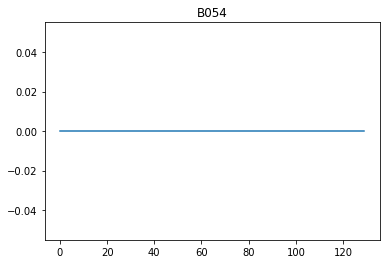

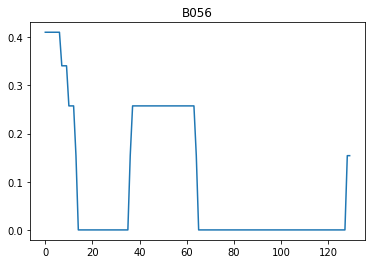

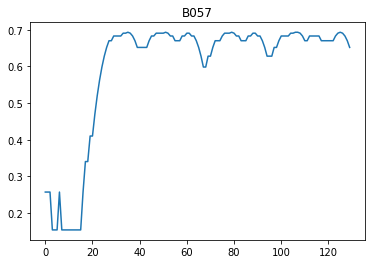

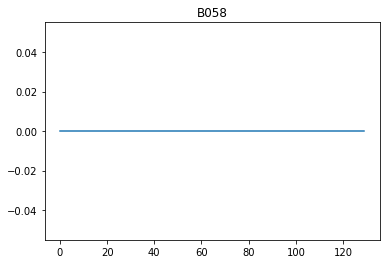

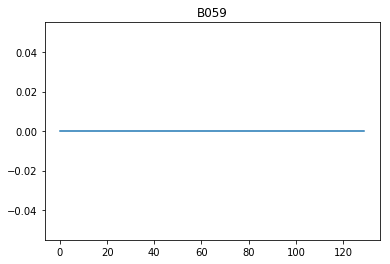

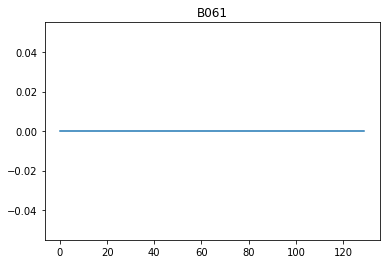

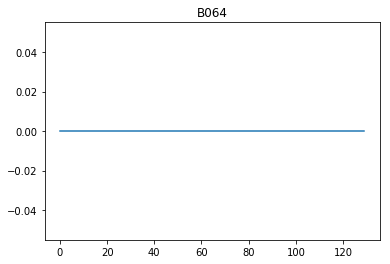

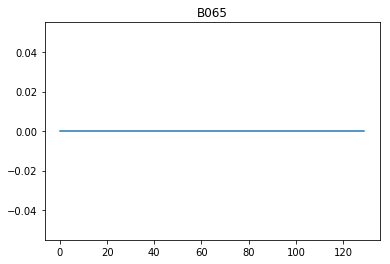

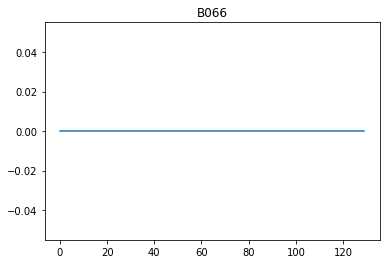

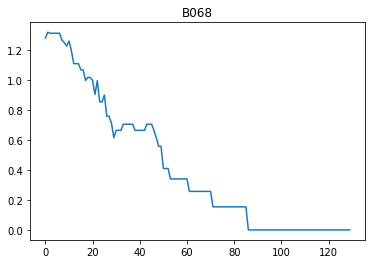

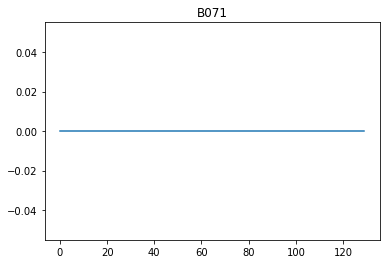

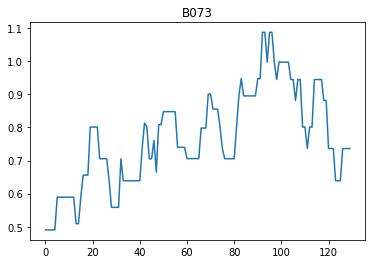

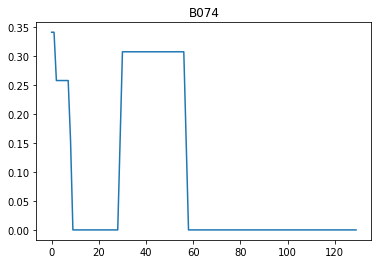

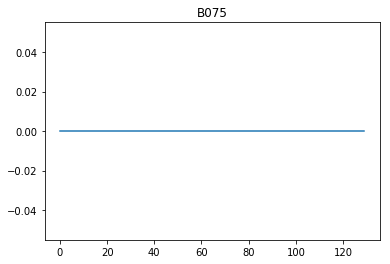

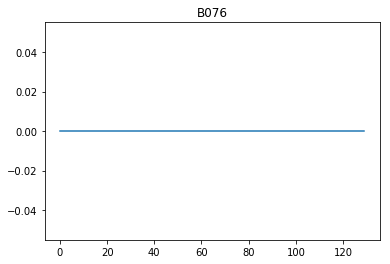

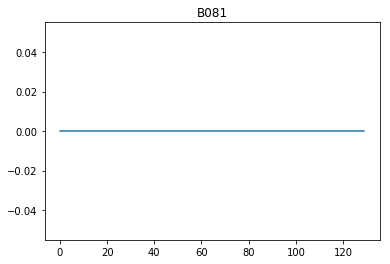

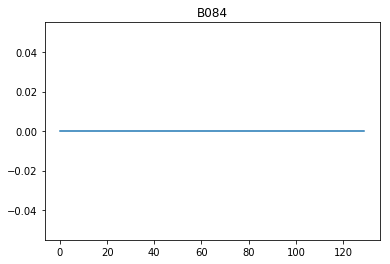

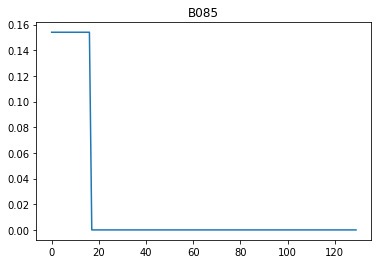

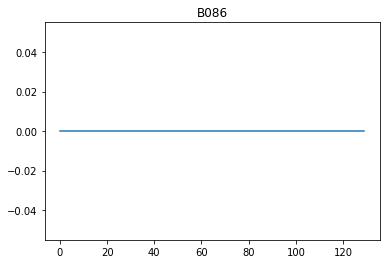

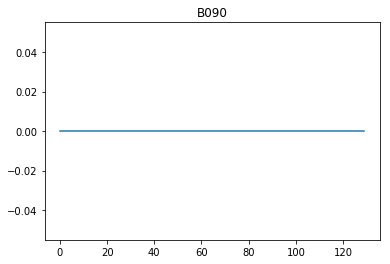

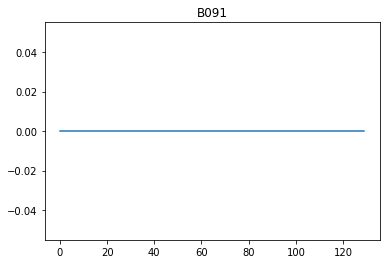

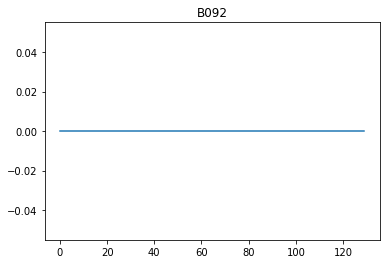

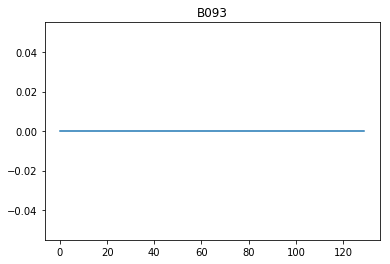

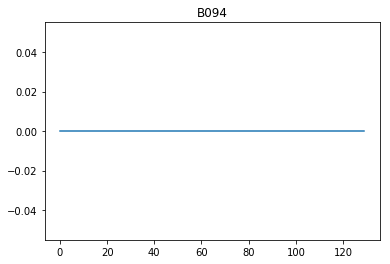

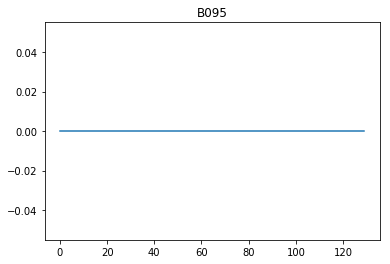

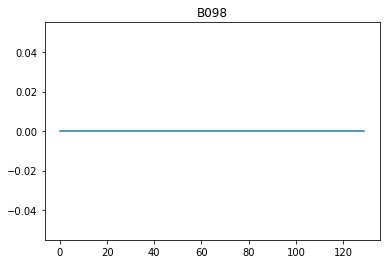

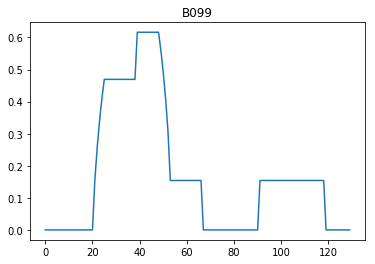

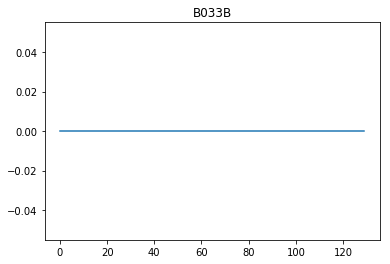

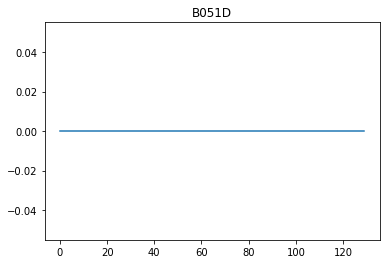

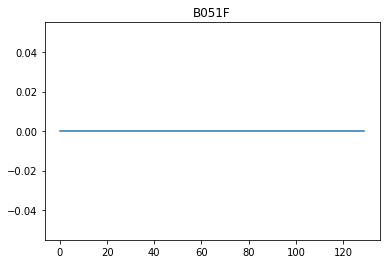

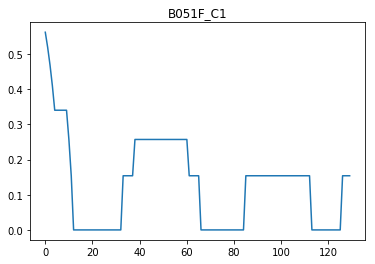

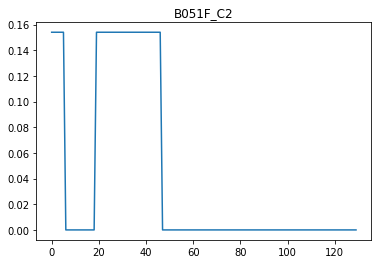

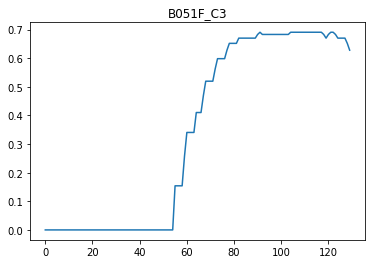

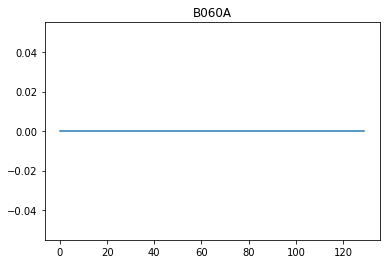

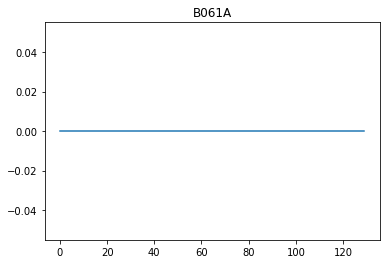

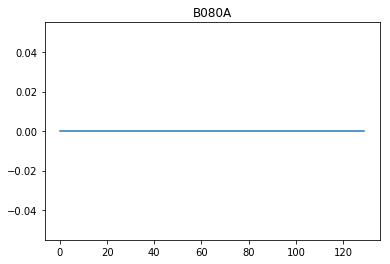

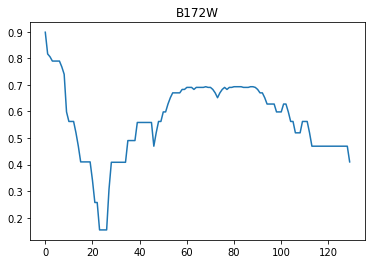

In [91]:
for i in range(0, len(wkday_bldg_arr[0])):
    plt.title(wkday_bldg_arr[0][i])
    plt.plot(bldg_entr_over_t_slide[i])
    plt.show()

In [83]:
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")

In [84]:
bldg_entr_over_t_slide

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0

In [85]:
entropy_sliding = pd.DataFrame(bldg_entr_over_t_slide)

In [86]:
wkday_bldg_arr[0]

['B101',
 'B103',
 'B104',
 'B107',
 'B108',
 'B109',
 'B110',
 'B111',
 'B114',
 'B115',
 'B116',
 'B117',
 'B118',
 'B119',
 'B123',
 'B124',
 'B126',
 'B129',
 'B130',
 'B131',
 'B132',
 'B135',
 'B136',
 'B138',
 'B139',
 'B141',
 'B144',
 'B145',
 'B146',
 'B147',
 'B148',
 'B149',
 'B151',
 'B152',
 'B153',
 'B155',
 'B158',
 'B159',
 'B160',
 'B165',
 'B167',
 'B170',
 'B173',
 'B177',
 'B180',
 'B181',
 'B182',
 'B184',
 'B189',
 'B196',
 'B199',
 'B200',
 'B203',
 'B302',
 'B318',
 'B320',
 'B336',
 'B362',
 'B790',
 'B002',
 'B003',
 'B006',
 'B007',
 'B008',
 'B009',
 'B010',
 'B011',
 'B012',
 'B013',
 'B014',
 'B015',
 'B017',
 'B018',
 'B020',
 'B022',
 'B024',
 'B025',
 'B026',
 'B029',
 'B030',
 'B031',
 'B032',
 'B033',
 'B035',
 'B036',
 'B038',
 'B039',
 'B040',
 'B041',
 'B045',
 'B046',
 'B047',
 'B050',
 'B051W',
 'B051',
 'B052',
 'B054',
 'B056',
 'B057',
 'B058',
 'B059',
 'B061',
 'B064',
 'B065',
 'B066',
 'B068',
 'B071',
 'B073',
 'B074',
 'B075',
 'B076',


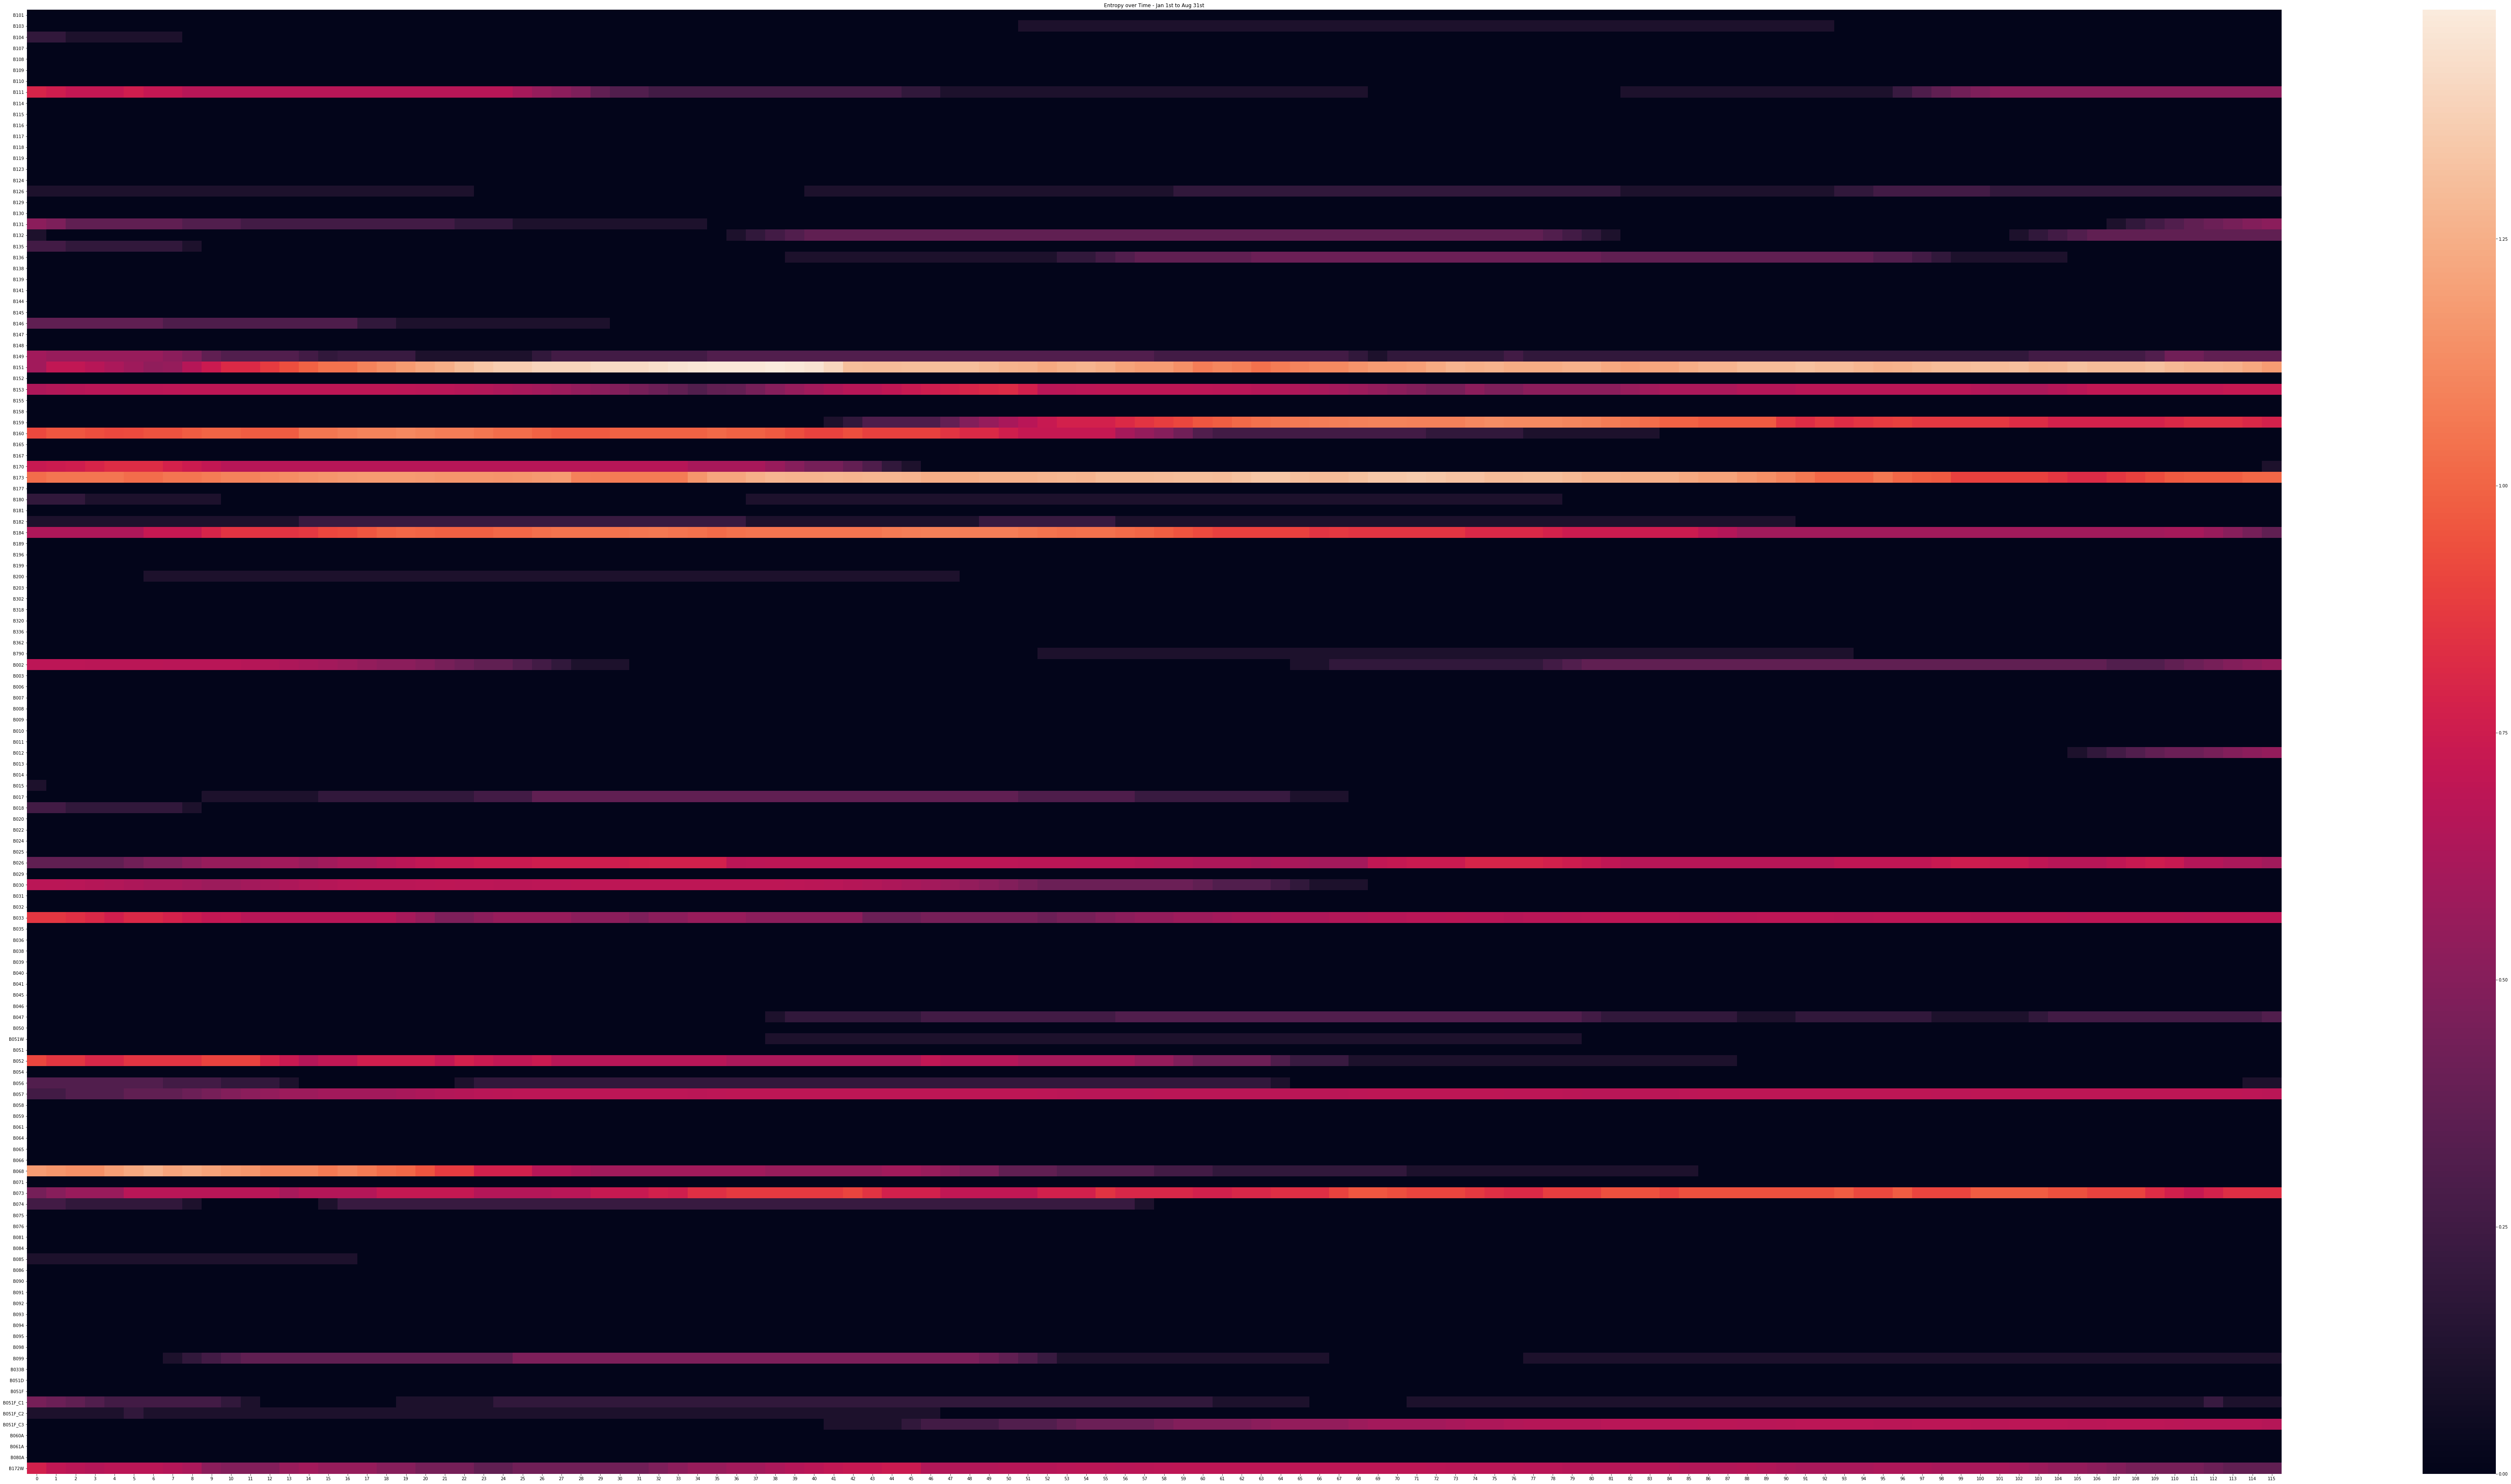

In [87]:
plt.figure(figsize=(120,64))
plt.title("Entropy over Time - Jan 1st to Aug 31st")
ax = sns.heatmap(bldg_entr_over_t_slide, yticklabels=wkday_bldg_arr[0])
plt.show()

In [88]:
#entropy_sliding[ entropy_sliding[:] > 0]

In [89]:
#entropy_sliding.iloc[:, 0].mean()